In [ ]:
# @title
import warnings
warnings.filterwarnings('ignore')


try:
    import cirq
except ImportError:
    print('installing cirq...')
    !pip install cirq --quiet
    import cirq
    print('installed cirq.')


#!git clone https://github.com/the-codingschool/bb84.git
#from bb84.bb84 import BB84
from cirq import NamedQubit, Simulator, Circuit

class BB84:

    """
    Implements the BB84 protocol for quantum key distribution.

    The BB84 protocol allows two parties, Alice and Bob, to generate a shared secret key, which can then be used
    for secure communication. The protocol also involves checking for the presence of an eavesdropper, Eve.
    This implementation provides a simulated environment for the protocol's execution, including the potential
    interception by Eve.


    <b>NOTE</b>:
        This class requires external definitions for the quantum circuits and simulator to function properly.

    <br>

    © 2024 The Coding School, All rights reserved.
    """

    qubit: NamedQubit
    """The qubit being used for the protocol. Must be defined externally, for example:
    ```python
    protocol.qubit = cirq.NamedQubit('q0')
    ```
    """

    simulator: Simulator
    """The quantum circuit simulator. Must be defined externally, for example:
    ```python
    protocol.simulator = cirq.Simulator()
    ```
    """

    alice_send_0_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_0_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_H_circuit = cirq.Circuit()
    ```
    """

    eve_intercept_circuit: Circuit
    """The quantum circuit that Eve will use to intercept the qubit between Phase 1 and 2. Must be defined externally, for example:
    ```python
    protocol.eve_intercept_circuit = cirq.Circuit()
    ```
    """

    bob_receive_no_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 without using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_no_H_circuit = cirq.Circuit()
    ```
    """

    bob_receive_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_H_circuit = cirq.Circuit()
    ```
    """


    eve_intercept: str
    """Indicates if Eve intercepts the qubits ('yes' or 'no'). Should be set upon initialization or after calling `reset()`."""

    alice_bit: int
    """The current bit Alice wants to send. Should only be modified indirectly through the `send_bit` method's parameters."""

    bob_bit: int
    """The bit received by Bob after measurement. Should only be modified indirectly through the `send_bit` method's parameters."""

    eve_bit: int
    """The bit measured by Eve if interception occurs. Should only be modified indirectly through the `send_bit` method's parameters."""

    does_alice_apply_H: str
    """Indicates if Alice applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""

    does_bob_apply_H: str
    """Indicates if Bob applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""


    alice_key: list
    """The secret key generated by Alice. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bob_key: list
    """The secret key generated by Bob. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    eve_key: list
    """The key intercepted by Eve, if any. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bit_num: int
    """Counter for the number of bits processed so far. <b>SHOULD NOT BE MODIFIED BY USER</b>."""


    def __init__(self, eve_intercept = 'no'):

      """
      Initializes the BB84 protocol simulation with default or specified settings.

      Parameters:
          `eve_intercept` (str, optional): Determines if Eve will attempt to intercept the qubits ('yes' or 'no').
                                         Defaults to 'no'.

      Example Usage:
      ```python
      protocol_without_eve = BB84()

      also_protocol_without_eve = BB84(eve_intercept = 'no')

      protocol_with_eve = BB84(eve_intercept = 'yes')
      ```
      """

      self.alice_bit = None
      self.bob_bit = None

      self.eve_bit = None
      self.eve_intercept = eve_intercept

      self.does_alice_apply_H = None
      self.does_bob_apply_H = None

      self.qubit = None
      self.simulator = None

      self.alice_send_0_no_H_circuit = None
      self.alice_send_1_no_H_circuit = None
      self.alice_send_0_H_circuit = None
      self.alice_send_1_H_circuit = None

      self.eve_intercept_circuit = None

      self.bob_receive_no_H_circuit = None
      self.bob_receive_H_circuit = None

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def phase_1_circuit(self):

      """
      Creates a circuit such that Alice encodes her bit into a qubit and applies an H gate if she's chosen to do so.
      Then she sends this qubit through her quantum channel to Bob, hoping Eve does not intercept.

      <b>Returns</b>:
          The quantum circuit for Phase 1 of BB84 (through Alice sending her qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.alice_bit == 0:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_0_no_H_circuit
        else:
          return self.alice_send_0_H_circuit

      else:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_1_no_H_circuit
        else:
          return self.alice_send_1_H_circuit


    def eve_circuit(self):

      """
      Creates a circuit for Eve's role in the protocol, which depends on if she's intercepting or not.

      <b>Returns</b>:
          The quantum circuit for Eve's interception if it occurs, otherwise an empty circuit.

      <b>INTERNAL USE ONLY</b>
      """

      if self.eve_intercept == 'yes':
        return self.eve_intercept_circuit
      else:
        return cirq.Circuit()


    def phase_2_circuit(self):

      """
      Creates a circuit such that Bob receives the qubit, applies an H gate if he's decided to do so,
      and then measures it.

      <b>Returns</b>:
          The quantum circuit for Phase 2 of BB84 (through Bob measuring the qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.does_bob_apply_H == 'no':
        return self.bob_receive_no_H_circuit
      else:
        return self.bob_receive_H_circuit


    def restart(self):

      """
      Resets the protocol such that the circuits are all the same, but they are being used with blank keys and on a new quantum channel.
      """

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def send_bit(self, alice_bit, does_alice_apply_H, does_bob_apply_H, compare_bits = 'no'):

      """
      Simulates the full BB84 protocol, potentially intercepted by Eve.

      Parameters:
        <ul>
          <li>`alice_bit` (int): The bit Alice wants to send.</li>
          <li>`does_alice_apply_H` (str): Indicates if Alice applies the Hadamard gate ('yes' or 'no').</li>
          <li>`does_bob_apply_H` (str): Indicates if Bob applies the Hadamard gate ('yes' or 'no').</li>
          <li>`compare_bit` (str, optional): Determines if Alice and Bob compare their bits directly ('yes' or 'no').
                                       Defaults to 'no'.</li>
        </ul>

      <b>NOTE</b>:
          This method simulates the entire process of sending a bit, including preparation, potential interception,
          and measurement. It also handles error checking for uninitialized objects that are required in the given case.


      Example Usage:
      ```python
      # Alice sends a 1 without an H gate and Bob receives and measures the qubit without an H gate.
      # The default is that they will not compare their bits and instead will add them to their key
      # if they both made the same choice of H gate or not.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no')


      # Same as above, except Alice and Bob will compare bits instead of adding them to their key.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no', compare_bits = 'yes')
      ```
      """

      self.alice_bit = alice_bit
      self.does_alice_apply_H = does_alice_apply_H
      self.does_bob_apply_H = does_bob_apply_H

      if self.qubit == None:
        print('Error: A qubit object must be defined first.')
        return

      elif self.simulator == None:
        print('Error: A simulator object must be defined first.')
        return


      # Prepare Alice's qubit
      alice_circuit = self.phase_1_circuit()

      if alice_circuit == None:

        applies_H = 'no H'
        if self.does_alice_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Alice\'s circuit for sending a', self.alice_bit, 'with', applies_H, 'must be defined first.')
        return


      # Eve's interception
      eve_circuit = self.eve_circuit()

      if eve_circuit == None:

        print('Error: Eve\'s interception circuit must be defined first.')
        return

      # Bob's measurement
      bob_circuit = self.phase_2_circuit()

      if bob_circuit == None:

        applies_H = 'no H'
        if self.does_bob_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Bob\'s circuit for measuring with', applies_H, 'must be defined first.')
        return

      # Combine circuits and run simulation
      bb84_circuit = alice_circuit + eve_circuit + bob_circuit
      results = self.simulator.run(bb84_circuit)
      self.bob_bit = results.measurements['q0'][0][0]

      if self.eve_intercept:
        self.eve_bit = results.measurements.get('eve', [[None]])[0][0]

      # Print results
      print('\033[43m\033[1mATTEMPTED BIT', self.bit_num, '\033[0m\033[0m')

      print('\n\033[32m\033[1mPHASE 1: SENDING\033[0m\033[0m\033[0m')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: I sent a', self.alice_bit, 'and', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')

      if self.eve_intercept == 'yes':
        print('EVE INTERCEPTS!')
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: I measured a', self.eve_bit, 'and will now send the qubit to Bob')

      print('\n\033[32m\033[1mPHASE 2: RECEIVING\033[0m\033[0m')
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H and measured a', self.bob_bit)

      print('\n\033[32m\033[1mPHASE 3: COMPARING\033[0m\033[0m')
      print('Alice and Bob are comparing choice of H\'s', 'and the bits themselves.' if compare_bits == 'yes' else 'but not the bits themselves.', '\n')
      print('\033[47m\033[1mAlice\033[0m\033[0m: I', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')
      print('\033[47m\033[1mBob\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H')

      print('')
      if compare_bits == 'yes':
        print('\033[47m\033[1mAlice\033[0m\033[0m: I sent a', self.alice_bit)
        print('\033[47m\033[1mBob\033[0m\033[0m: I measured a', self.bob_bit, '\n')

        if self.does_alice_apply_H == self.does_bob_apply_H:
          if self.alice_bit == self.bob_bit:
            print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Our bits match, so it doesn\'t seem like Eve is intercepting.')

            if self.eve_intercept == 'yes':
              print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: Mwuhaha, I\'ve gone undetected.')

          else:
            print('\033[91m\033[1mAlice and Bob: Our bits are different, so Eve must have intercepted! Let\'s start over with new keys and a new quantum channel!\033[0m\033[0m')
            self.restart()

        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      else:
        if self.does_alice_apply_H == self.does_bob_apply_H:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Great, let\'s add this bit to our keys.')
          self.alice_key += [self.alice_bit]
          self.bob_key += [self.bob_bit]

          if self.eve_intercept:
            self.eve_key += [self.eve_bit]
        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      print('')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: My key is now', self.alice_key)
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: My key is now', self.bob_key)

      if self.eve_intercept == 'yes':
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: My key is now:', self.eve_key)


      print('\nThe circuit used this round:', bb84_circuit)

      self.bit_num += 1
      print('='*75, end='\n\n')

import matplotlib.pyplot as plt

installing cirq...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.2 MB/s eta 0:00:00
installed cirq.


Alice's Bits:  [1 0 1 1 0 1 0 0]
Alice's Bases:  ['X' 'Z' 'X' 'Z' 'X' 'Z' 'Z' 'Z']
Bob's Bases:   ['X' 'Z' 'X' 'Z' 'Z' 'X' 'Z' 'X']
Measurements:  {'m0': 1, 'm1': 0, 'm2': 1, 'm3': 1, 'm4': 0, 'm5': 0, 'm6': 0, 'm7': 1}
Shared Key:    [1, 0, 1, 1, None, None, 0, None]


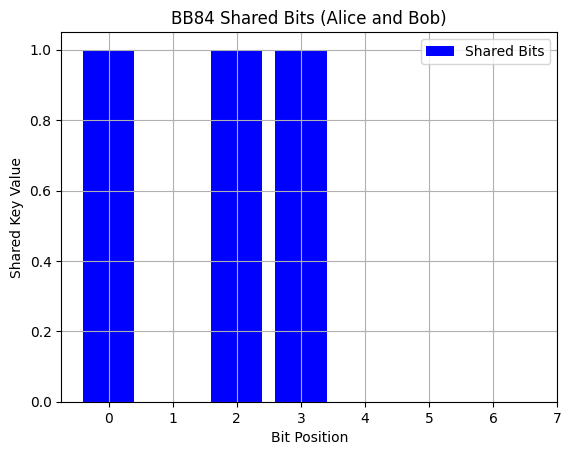

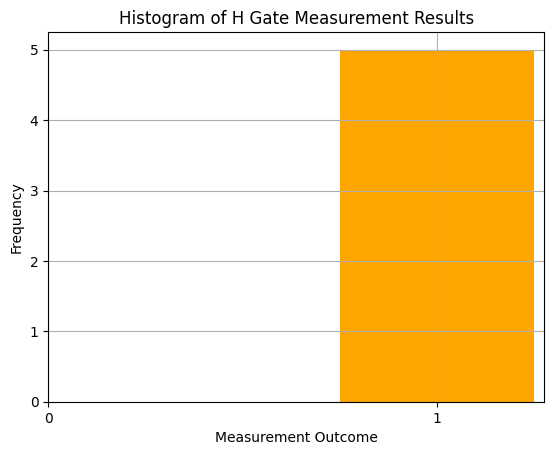

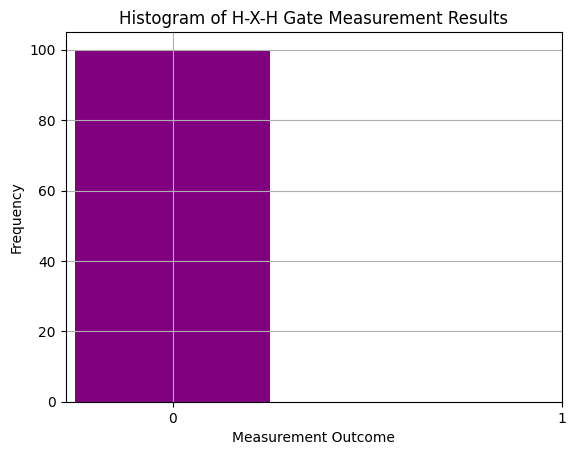

0: ───H───X───H───M('result')───

In [ ]:
import numpy as np
from collections import Counter


def bb84_protocol(num_bits=8):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Bob's random bases
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    # Step 3: Cirq simulation of qubits and gates
    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    circuit = cirq.Circuit()

    # Apply gates for Alice
    for i in range(num_bits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))

    # Apply measurement in Bob's bases
    for i in range(num_bits):
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))
        circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=1)
    measurements = {f'm{i}': int(results.measurements[f'm{i}'][0]) for i in range(num_bits)}

    print("Measurements: ", measurements)

    # Key agreement (compare bases)
    shared_key = []
    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key.append(alice_bits[i])
        else:
            shared_key.append(None)

    print("Shared Key:   ", shared_key)

    # Visualization: Correctly shared bits
    valid_positions = [i for i in range(num_bits) if shared_key[i] is not None]
    plt.bar(valid_positions, [shared_key[i] for i in valid_positions], color='blue', label="Shared Bits")
    plt.xticks(range(num_bits))
    plt.title("BB84 Shared Bits (Alice and Bob)")
    plt.xlabel("Bit Position")
    plt.ylabel("Shared Key Value")
    plt.legend()
    plt.grid()
    plt.show()

    # Return data
    return circuit, shared_key

def apply_h_gate_measurements(repetitions=5):
    # Apply H and measure
    qubit = cirq.LineQubit(0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)

    # Plot histogram
    measurements = np.array(result.measurements['result']).flatten()
    counts = Counter(measurements)
    plt.bar(counts.keys(), counts.values(), color='orange', width=0.5)
    plt.title("Histogram of H Gate Measurement Results")
    plt.xticks([0, 1], labels=['0', '1'])
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
    return circuit

def apply_h_x_h_gate_measurements(repetitions=100):
    # Apply H, X, H, and measure
    qubit = cirq.LineQubit(0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.X(qubit), cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)

    # Plot histogram
    measurements = np.array(result.measurements['result']).flatten()
    counts = Counter(measurements)
    plt.bar(counts.keys(), counts.values(), color='purple', width=0.5)
    plt.title("Histogram of H-X-H Gate Measurement Results")
    plt.xticks([0, 1], labels=['0', '1'])
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
    return circuit

# Run the BB84 Protocol
bb84_protocol()

# Run basic measurements for H gate
apply_h_gate_measurements()

# Run extended measurements for H-X-H gate
apply_h_x_h_gate_measurements()


Alice's Bits:  [1 1 0 0 0 0 0 1]
Alice's Bases:  ['X' 'X' 'X' 'Z' 'X' 'X' 'X' 'X']
Eve's Measurements:  [1, 0, 0, 1, 1, 0, 0, 1]
Bob's Bases:   ['Z' 'X' 'Z' 'Z' 'Z' 'Z' 'Z' 'X']
Bob's Measurements:  [0, 0, 0, 0, 1, 0, 0, 1]
Shared Key with Eve:  [None, 1, None, 0, None, None, None, 1]
Error Rate Introduced by Eve: 12.50%


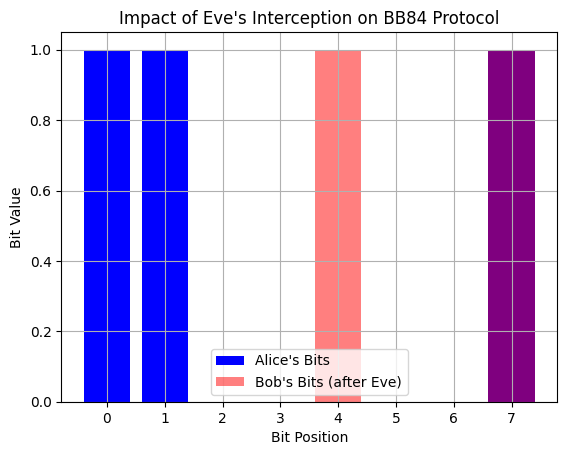

In [ ]:
def bb84_with_eve(num_bits=8):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Eve intercepts the qubits
    eve_bases = np.random.choice(['Z', 'X'], size=num_bits)
    eve_measurements = []

    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    eve_circuit = cirq.Circuit()

    for i in range(num_bits):
        if alice_bits[i] == 1:
            eve_circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))
        if eve_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))
        eve_circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate Eve's interception
    simulator = cirq.Simulator()
    eve_result = simulator.run(eve_circuit, repetitions=1)
    eve_measurements = [int(eve_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Eve's Measurements: ", eve_measurements)

    # Eve retransmits qubits
    eve_circuit_transmit = cirq.Circuit()
    for i in range(num_bits):
        if eve_measurements[i] == 1:
            eve_circuit_transmit.append(cirq.X(qubits[i]))
        if eve_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))

    # Step 3: Bob measures the intercepted qubits
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    for i in range(num_bits):
        if bob_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))
        eve_circuit_transmit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate Bob's measurement
    bob_result = simulator.run(eve_circuit_transmit, repetitions=1)
    bob_measurements = [int(bob_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Bob's Measurements: ", bob_measurements)

    # Step 4: Key agreement and error analysis
    shared_key_with_eve = []
    errors = 0
    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key_with_eve.append(alice_bits[i])
            if alice_bits[i] != bob_measurements[i]:
                errors += 1
        else:
            shared_key_with_eve.append(None)

    print("Shared Key with Eve: ", shared_key_with_eve)
    print(f"Error Rate Introduced by Eve: {errors / num_bits * 100:.2f}%")

    # Visualization: Error Rate
    plt.bar(range(num_bits), alice_bits, color='blue', label="Alice's Bits")
    plt.bar(range(num_bits), bob_measurements, alpha=0.5, color='red', label="Bob's Bits (after Eve)")
    plt.xticks(range(num_bits))
    plt.title("Impact of Eve's Interception on BB84 Protocol")
    plt.xlabel("Bit Position")
    plt.ylabel("Bit Value")
    plt.legend()
    plt.grid()
    plt.show()

    # Return data
    return shared_key_with_eve, errors / num_bits

# Run the BB84 Protocol with Eve
shared_key, error_rate = bb84_with_eve()


Alice's Bits:  [0 1 1 1 1 1 0 1]
Alice's Bases:  ['X' 'X' 'Z' 'Z' 'Z' 'X' 'X' 'Z']
Bob's Bases:   ['Z' 'Z' 'X' 'X' 'X' 'X' 'Z' 'X']
Original Measurements:  {'m0': 1, 'm1': 0, 'm2': 0, 'm3': 1, 'm4': 1, 'm5': 1, 'm6': 0, 'm7': 1}
Noisy Measurements:     {'m0': 1, 'm1': 0, 'm2': 0, 'm3': 0, 'm4': 1, 'm5': 1, 'm6': 0, 'm7': 1}
Shared Key:    [None, None, None, None, None, 1, None, None]


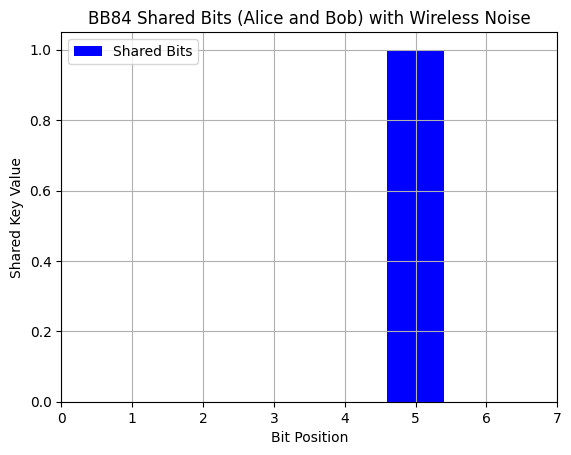

(0: ───H───M('m0')───────────────────────

1: ───X───H─────────M('m1')─────────────

2: ───X───H─────────M('m2')─────────────

3: ───X───H─────────M('m3')─────────────

4: ───X───H─────────M('m4')─────────────

5: ───X───H─────────H─────────M('m5')───

6: ───H───M('m6')───────────────────────

7: ───X───H─────────M('m7')─────────────,
 [None, None, None, None, None, 1, None, None],
 {'m0': 1, 'm1': 0, 'm2': 0, 'm3': 0, 'm4': 1, 'm5': 1, 'm6': 0, 'm7': 1})

In [ ]:
def simulate_wireless_noise(measurements, noise_prob=0.1):
    """
    Simulate a wireless channel introducing random bit flips (errors) with given noise probability.
    """
    noisy_measurements = measurements.copy()
    for key in noisy_measurements:
        if np.random.rand() < noise_prob:
            noisy_measurements[key] = 1 - noisy_measurements[key]  # Flip bit
    return noisy_measurements

def bb84_protocol_with_noise(num_bits=8, noise_prob=0.1):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Bob's random bases
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    # Step 3: Cirq simulation of qubits and gates
    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    circuit = cirq.Circuit()

    # Apply gates for Alice
    for i in range(num_bits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))

    # Apply measurement in Bob's bases
    for i in range(num_bits):
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))
        circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=1)
    measurements = {f'm{i}': int(results.measurements[f'm{i}'][0]) for i in range(num_bits)}
    print("Original Measurements: ", measurements)

    # Step 4: Introduce wireless noise
    noisy_measurements = simulate_wireless_noise(measurements, noise_prob=noise_prob)
    print("Noisy Measurements:    ", noisy_measurements)

    # Key agreement (compare bases)
    shared_key = []
    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            if noisy_measurements[f'm{i}'] == alice_bits[i]:  # Correct bit after noise
                shared_key.append(alice_bits[i])
            else:
                shared_key.append(None)  # Drop mismatched bit
        else:
            shared_key.append(None)

    print("Shared Key:   ", shared_key)

    # Visualization: Correctly shared bits
    valid_positions = [i for i in range(num_bits) if shared_key[i] is not None]
    plt.bar(valid_positions, [shared_key[i] for i in valid_positions], color='blue', label="Shared Bits")
    plt.xticks(range(num_bits))
    plt.title("BB84 Shared Bits (Alice and Bob) with Wireless Noise")
    plt.xlabel("Bit Position")
    plt.ylabel("Shared Key Value")
    plt.legend()
    plt.grid()
    plt.show()

    # Return data
    return circuit, shared_key, noisy_measurements

# Simulate the BB84 protocol with wireless channel noise
num_bits = 8  # Number of bits/qubits
noise_probability = 0.2  # Probability of noise causing a bit flip
bb84_protocol_with_noise(num_bits=num_bits, noise_prob=noise_probability)

Alice's Bits:  [1 0 0 0 0 1 1 1]
Alice's Bases:  ['Z' 'X' 'X' 'X' 'X' 'X' 'Z' 'X']
Eve's Measurements:  [1, 0, 0, 0, 0, 1, 1, 1]
Bob's Bases:   ['X' 'X' 'X' 'Z' 'X' 'Z' 'X' 'Z']
Bob's Measurements:  [1, 0, 0, 1, 0, 0, 1, 0]
Shared Key with Eve:  [None, 0, 0, None, 0, None, None, None]
Error Rate Introduced by Eve: 0.00%


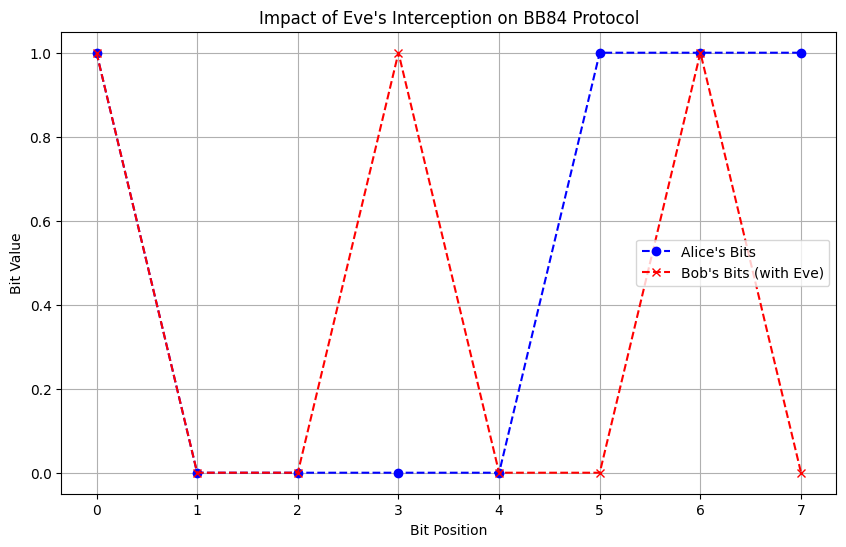

In [ ]:
import numpy as np

def bb84_with_eve(num_bits=8, error_probability=0.1):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Eve intercepts the qubits
    eve_bases = np.random.choice(['Z', 'X'], size=num_bits)
    eve_measurements = []

    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    eve_circuit = cirq.Circuit()

    for i in range(num_bits):
        if alice_bits[i] == 1:
            eve_circuit.append(cirq.X(qubits[i]))  # Prepare qubit based on Alice's bit
        if alice_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))  # Rotate qubit if Alice chose the 'X' basis
        if eve_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))  # Eve rotates to random basis
        eve_circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate Eve's interception
    simulator = cirq.Simulator()
    eve_result = simulator.run(eve_circuit, repetitions=1)
    eve_measurements = [int(eve_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Eve's Measurements: ", eve_measurements)

    # Eve retransmits qubits
    eve_circuit_transmit = cirq.Circuit()
    for i in range(num_bits):
        if eve_measurements[i] == 1:
            eve_circuit_transmit.append(cirq.X(qubits[i]))  # Apply correction if Eve measured '1'
        if eve_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))  # Adjust the qubit back if Eve rotated it

    # Step 3: Bob measures the intercepted qubits
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    for i in range(num_bits):
        if bob_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))  # Rotate qubit if Bob chooses 'X' basis
        eve_circuit_transmit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate Bob's measurement
    bob_result = simulator.run(eve_circuit_transmit, repetitions=1)
    bob_measurements = [int(bob_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Bob's Measurements: ", bob_measurements)

    # Step 4: Key agreement and error analysis
    shared_key_with_eve = []
    errors = 0
    detected_errors = []  # List to store positions of errors

    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key_with_eve.append(alice_bits[i])
            # Introduce random measurement errors
            if np.random.rand() < error_probability:  # Simulating real-world noise
                bob_measurements[i] = 1 - bob_measurements[i]  # Flip bit with some probability
            if alice_bits[i] != bob_measurements[i]:
                errors += 1
                detected_errors.append(i)  # Record position of error
        else:
            shared_key_with_eve.append(None)

    print("Shared Key with Eve: ", shared_key_with_eve)
    print(f"Error Rate Introduced by Eve: {errors / num_bits * 100:.2f}%")

    # Visualization: Error Rate
    plt.figure(figsize=(10, 6))

    # Plot Alice's and Bob's bits, using different markers for errors
    plt.plot(range(num_bits), alice_bits, marker='o', color='blue', label="Alice's Bits", linestyle='--')
    plt.plot(range(num_bits), bob_measurements, marker='x', color='red', label="Bob's Bits (with Eve)", linestyle='--')

    # Highlight errors with a scatter plot
    if detected_errors:
        error_x = np.array(detected_errors)
        error_y = np.array([bob_measurements[i] for i in detected_errors])
        plt.scatter(error_x, error_y, color='black', zorder=5, label="Errors Detected")

    plt.xticks(range(num_bits))
    plt.title("Impact of Eve's Interception on BB84 Protocol")
    plt.xlabel("Bit Position")
    plt.ylabel("Bit Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return data
    return shared_key_with_eve, errors / num_bits

# Run the BB84 Protocol with Eve
shared_key, error_rate = bb84_with_eve()

Alice's Bits:  [0 1 1 1 1 0 0 1]
Alice's Bases:  ['Z' 'Z' 'Z' 'X' 'X' 'Z' 'X' 'Z']
Bob's Bases:   ['X' 'Z' 'Z' 'Z' 'X' 'Z' 'X' 'Z']
Bob's Measurements:  [0, 0, 0, 0, 0, 0, 1, 0]
Shared Key without Eve:  [None, 1, 1, None, 1, 0, 0, 1]
Error Rate in the Absence of Eve: 62.50%


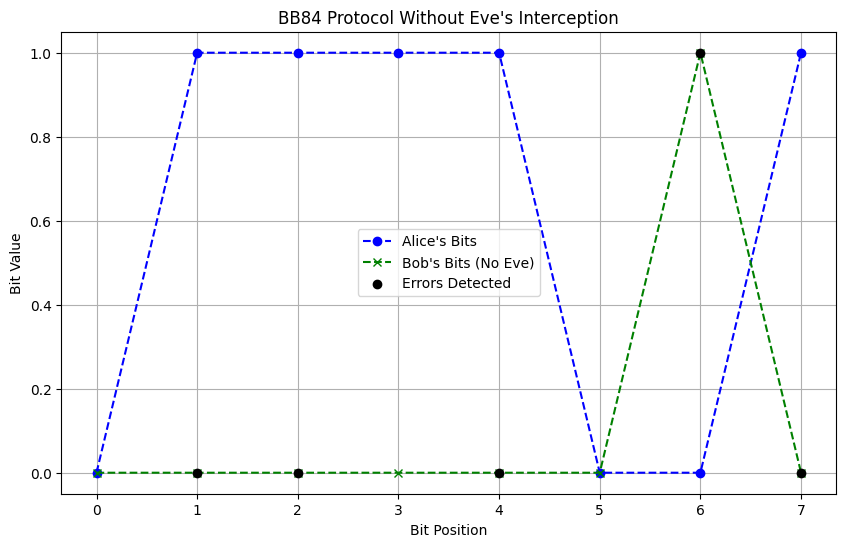

In [ ]:
import numpy as np

def bb84_no_eve(num_bits=8, error_probability=0.1):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Bob's measurement
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    # Initialize qubits and circuit for Alice sending qubits directly to Bob
    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    alice_circuit = cirq.Circuit()

    for i in range(num_bits):
        if alice_bits[i] == 1:
            alice_circuit.append(cirq.X(qubits[i]))  # Alice prepares the bit
        if alice_bases[i] == 'X':
            alice_circuit.append(cirq.H(qubits[i]))  # Alice applies X basis if needed
        alice_circuit.append(cirq.measure(qubits[i], key=f'm{i}'))  # Alice adds measurement

    # Step 3: Bob's measurement circuit
    bob_circuit = cirq.Circuit()

    for i in range(num_bits):
        if bob_bases[i] == 'X':
            bob_circuit.append(cirq.H(qubits[i]))  # Bob applies X basis if needed
        bob_circuit.append(cirq.measure(qubits[i], key=f'm{i}'))  # Bob measures the qubits

    # Simulate the Alice's and Bob's circuits
    simulator = cirq.Simulator()

    # Run the simulation for both Alice and Bob
    alice_result = simulator.run(alice_circuit, repetitions=1)
    bob_result = simulator.run(bob_circuit, repetitions=1)

    # Collect Bob's measurements
    bob_measurements = [int(bob_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Bob's Measurements: ", bob_measurements)

    # Step 4: Key agreement and error analysis
    shared_key_no_eve = []
    errors = 0
    detected_errors = []  # List to store positions of errors

    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key_no_eve.append(alice_bits[i])
            # Introduce random measurement errors
            if np.random.rand() < error_probability:  # Simulating real-world noise
                bob_measurements[i] = 1 - bob_measurements[i]  # Flip bit with some probability
            if alice_bits[i] != bob_measurements[i]:
                errors += 1
                detected_errors.append(i)  # Record position of error
        else:
            shared_key_no_eve.append(None)

    print("Shared Key without Eve: ", shared_key_no_eve)
    print(f"Error Rate in the Absence of Eve: {errors / num_bits * 100:.2f}%")

    # Visualization: Error Rate without Eve
    plt.figure(figsize=(10, 6))

    # Plot Alice's and Bob's bits, using different markers for errors
    plt.plot(range(num_bits), alice_bits, marker='o', color='blue', label="Alice's Bits", linestyle='--')
    plt.plot(range(num_bits), bob_measurements, marker='x', color='green', label="Bob's Bits (No Eve)", linestyle='--')

    # Highlight errors with a scatter plot
    if detected_errors:
        error_x = np.array(detected_errors)
        error_y = np.array([bob_measurements[i] for i in detected_errors])
        plt.scatter(error_x, error_y, color='black', zorder=5, label="Errors Detected")

    plt.xticks(range(num_bits))
    plt.title("BB84 Protocol Without Eve's Interception")
    plt.xlabel("Bit Position")
    plt.ylabel("Bit Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return data
    return shared_key_no_eve, errors / num_bits

# Run the BB84 Protocol Without Eve's Interception
shared_key_no_eve, error_rate_no_eve = bb84_no_eve()

Alice's Bits:  [0 1 1 1 1 0 0 1]
Alice's Bases:  ['Z' 'Z' 'Z' 'X' 'X' 'Z' 'X' 'Z']
Eve's Measurements:  [1, 0, 0, 0, 1, 0, 0, 0]
Bob's Bases:   ['X' 'Z' 'Z' 'Z' 'X' 'Z' 'X' 'Z']
Bob's Measurements:  [1, 1, 1, 0, 1, 0, 0, 0]
Shared Key with Eve:  [None, 1, 1, None, 1, 0, 0, 1]
Error Rate Introduced by Eve: 12.50%


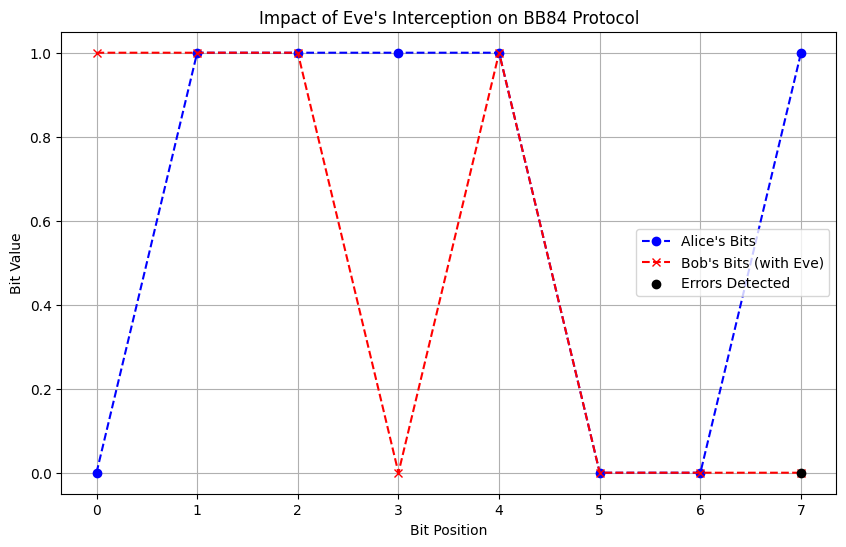

In [ ]:
def bb84_with_eve(num_bits=8, error_probability=0.1):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.array([0, 1, 1, 1, 1, 0, 0, 1])  # Pre-defined Alice's bits
    alice_bases = np.array(['Z', 'Z', 'Z', 'X', 'X', 'Z', 'X', 'Z'])  # Pre-defined Alice's bases
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Eve intercepts the qubits
    eve_bases = np.random.choice(['Z', 'X'], size=num_bits)
    eve_measurements = []

    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    eve_circuit = cirq.Circuit()

    for i in range(num_bits):
        if alice_bits[i] == 1:
            eve_circuit.append(cirq.X(qubits[i]))  # Prepare qubit based on Alice's bit
        if alice_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))  # Rotate qubit if Alice chose the 'X' basis
        if eve_bases[i] == 'X':
            eve_circuit.append(cirq.H(qubits[i]))  # Eve rotates to random basis
        eve_circuit.append(cirq.measure(qubits[i], key=f'm{i}'))  # Eve intercepts the measurement

    # Simulate Eve's interception
    simulator = cirq.Simulator()
    eve_result = simulator.run(eve_circuit, repetitions=1)
    eve_measurements = [int(eve_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Eve's Measurements: ", eve_measurements)

    # Eve retransmits qubits
    eve_circuit_transmit = cirq.Circuit()
    for i in range(num_bits):
        if eve_measurements[i] == 1:
            eve_circuit_transmit.append(cirq.X(qubits[i]))  # Apply correction if Eve measured '1'
        if eve_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))  # Adjust the qubit back if Eve rotated it

    # Step 3: Bob measures the intercepted qubits
    bob_bases = np.array(['X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'Z'])  # Pre-defined Bob's bases
    print("Bob's Bases:  ", bob_bases)

    for i in range(num_bits):
        if bob_bases[i] == 'X':
            eve_circuit_transmit.append(cirq.H(qubits[i]))  # Rotate qubit if Bob chooses 'X' basis
        eve_circuit_transmit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate Bob's measurement
    bob_result = simulator.run(eve_circuit_transmit, repetitions=1)
    bob_measurements = [int(bob_result.measurements[f'm{i}'][0]) for i in range(num_bits)]
    print("Bob's Measurements: ", bob_measurements)

    # Step 4: Key agreement and error analysis
    shared_key_with_eve = []
    errors = 0
    detected_errors = []  # List to store positions of errors

    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key_with_eve.append(alice_bits[i])
            # Introduce random measurement errors
            if np.random.rand() < error_probability:  # Simulating real-world noise
                bob_measurements[i] = 1 - bob_measurements[i]  # Flip bit with some probability
            if alice_bits[i] != bob_measurements[i]:
                errors += 1
                detected_errors.append(i)  # Record position of error
        else:
            shared_key_with_eve.append(None)

    print("Shared Key with Eve: ", shared_key_with_eve)
    print(f"Error Rate Introduced by Eve: {errors / num_bits * 100:.2f}%")

    # Visualization: Error Rate
    plt.figure(figsize=(10, 6))

    # Plot Alice's and Bob's bits, using different markers for errors
    plt.plot(range(num_bits), alice_bits, marker='o', color='blue', label="Alice's Bits", linestyle='--')
    plt.plot(range(num_bits), bob_measurements, marker='x', color='red', label="Bob's Bits (with Eve)", linestyle='--')

    # Highlight errors with a scatter plot
    if detected_errors:
        error_x = np.array(detected_errors)
        error_y = np.array([bob_measurements[i] for i in detected_errors])
        plt.scatter(error_x, error_y, color='black', zorder=5, label="Errors Detected")

    plt.xticks(range(num_bits))
    plt.title("Impact of Eve's Interception on BB84 Protocol")
    plt.xlabel("Bit Position")
    plt.ylabel("Bit Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return data
    return shared_key_with_eve, errors / num_bits

# Run the BB84 Protocol with Eve
shared_key_with_eve, error_rate_with_eve = bb84_with_eve(error_probability=0.1)

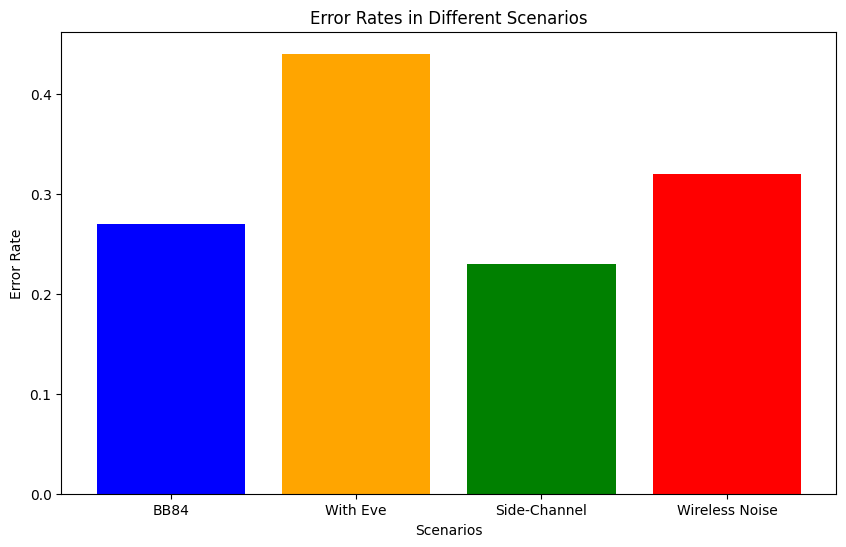

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Shared Input Data
num_qubits = 100  # Number of qubits for the simulation
np.random.seed(42)  # Seed for reproducibility
alice_bits = np.random.randint(2, size=num_qubits)  # Alice's bits
alice_bases = np.random.choice(["+", "x"], size=num_qubits)  # Alice's measurement bases

# Utility Function to Run a Circuit and Measure
def run_circuit(circuit, repetitions=1):
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)
    return np.array(result.measurements['result']).flatten()

# Simulation: Simple BB84 (No Eve, No Errors)
def simulate_bb84(alice_bits, alice_bases, bob_bases):
    measurement_outcomes = []

    for bit, alice_basis, bob_basis in zip(alice_bits, alice_bases, bob_bases):
        qubit = cirq.LineQubit(0)
        circuit = cirq.Circuit()

        if bit == 1:
            circuit.append(cirq.X(qubit))  # Prepare |1>

        if alice_basis == "x":
            circuit.append(cirq.H(qubit))  # Change to |+> or |->

        if bob_basis == "x":
            circuit.append(cirq.H(qubit))  # Bob measures in Hadamard basis

        circuit.append(cirq.measure(qubit, key='result'))
        measurement_outcomes.append(run_circuit(circuit)[0])

    return np.array(measurement_outcomes)

# Alice and Bob simulate BB84
bob_bases = np.random.choice(["+", "x"], size=num_qubits)  # Bob's measurement bases
bob_measurements_bb84 = simulate_bb84(alice_bits, alice_bases, bob_bases)

# Add scenarios: Eve Intercepts, Side Channel, Wireless Channel

def simulate_with_eve(alice_bits, alice_bases, bob_bases):
    eve_bases = np.random.choice(["+", "x"], size=num_qubits)
    measurement_outcomes = []

    for bit, alice_basis, eve_basis, bob_basis in zip(alice_bits, alice_bases, eve_bases, bob_bases):
        qubit = cirq.LineQubit(0)
        circuit = cirq.Circuit()

        if bit == 1:
            circuit.append(cirq.X(qubit))

        if alice_basis == "x":
            circuit.append(cirq.H(qubit))

        # Eve measures
        if eve_basis == "x":
            circuit.append(cirq.H(qubit))
        circuit.append(cirq.measure(qubit, key='result'))
        eve_measurement = run_circuit(circuit)[0]

        # Re-prepare by Eve
        circuit = cirq.Circuit()
        if eve_measurement == 1:
            circuit.append(cirq.X(qubit))
        if alice_basis == "x":
            circuit.append(cirq.H(qubit))
        if bob_basis == "x":
            circuit.append(cirq.H(qubit))

        circuit.append(cirq.measure(qubit, key='result'))
        measurement_outcomes.append(run_circuit(circuit)[0])

    return np.array(measurement_outcomes)

bob_measurements_eve = simulate_with_eve(alice_bits, alice_bases, bob_bases)

# Side-Channel Attack
def simulate_side_channel(alice_bits, alice_bases, bob_bases, error_rate=0.1):
    measurement_outcomes = []

    for bit, alice_basis, bob_basis in zip(alice_bits, alice_bases, bob_bases):
        qubit = cirq.LineQubit(0)
        circuit = cirq.Circuit()

        if bit == 1:
            circuit.append(cirq.X(qubit))

        if alice_basis == "x":
            circuit.append(cirq.H(qubit))

        # Introducing side-channel noise
        if np.random.rand() < error_rate:
            circuit.append(cirq.X(qubit))

        if bob_basis == "x":
            circuit.append(cirq.H(qubit))

        circuit.append(cirq.measure(qubit, key='result'))
        measurement_outcomes.append(run_circuit(circuit)[0])

    return np.array(measurement_outcomes)

bob_measurements_side_channel = simulate_side_channel(alice_bits, alice_bases, bob_bases)

# Wireless Channel Noise
def simulate_wireless_channel(alice_bits, alice_bases, bob_bases, noise_rate=0.2):
    measurement_outcomes = []

    for bit, alice_basis, bob_basis in zip(alice_bits, alice_bases, bob_bases):
        qubit = cirq.LineQubit(0)
        circuit = cirq.Circuit()

        if bit == 1:
            circuit.append(cirq.X(qubit))

        if alice_basis == "x":
            circuit.append(cirq.H(qubit))

        # Introducing wireless noise
        if np.random.rand() < noise_rate:
            circuit.append(cirq.X(qubit))

        if bob_basis == "x":
            circuit.append(cirq.H(qubit))

        circuit.append(cirq.measure(qubit, key='result'))
        measurement_outcomes.append(run_circuit(circuit)[0])

    return np.array(measurement_outcomes)

bob_measurements_noise = simulate_wireless_channel(alice_bits, alice_bases, bob_bases)

# Calculate Error Rates
def calculate_error_rate(alice_bits, bob_measurements):
    return np.mean(alice_bits != bob_measurements)

error_bb84 = calculate_error_rate(alice_bits, bob_measurements_bb84)
error_eve = calculate_error_rate(alice_bits, bob_measurements_eve)
error_side_channel = calculate_error_rate(alice_bits, bob_measurements_side_channel)
error_noise = calculate_error_rate(alice_bits, bob_measurements_noise)

# Display Comparative Errors
scenarios = ["BB84", "With Eve", "Side-Channel", "Wireless Noise"]
errors = [error_bb84, error_eve, error_side_channel, error_noise]

plt.figure(figsize=(10, 6))
plt.bar(scenarios, errors, color=['blue', 'orange', 'green', 'red'])
plt.title("Error Rates in Different Scenarios")
plt.xlabel("Scenarios")
plt.ylabel("Error Rate")
plt.show()


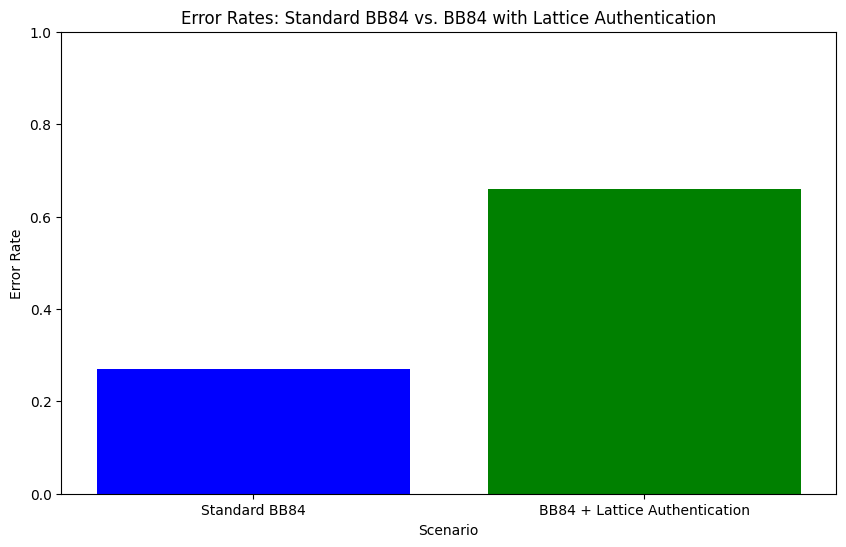

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Shared Variables
num_qubits = 100
np.random.seed(42)
alice_bits = np.random.randint(2, size=num_qubits)
alice_bases = np.random.choice(["Z", "X"], size=num_qubits)

# Lattice-Based Authentication (key integrity)
def lattice_authenticate(shared_secret, noise=0.1):
    """Simulates lattice-based authentication with noise mitigation."""
    noisy_secret = shared_secret + np.random.normal(0, noise, size=len(shared_secret))
    # Reduce noise by using a threshold (for simplicity, we use rounding)
    return np.round(noisy_secret) == shared_secret

# Error Correction using Syndrome Coding (quantum error correction)
def syndrome_error_correction(bit_string):
    """Basic syndrome error correction (corrects bit-flip errors)."""
    corrected = []
    for i in range(len(bit_string)):
        # Example correction: flip if there is a 1-flip error detected (simple model)
        if bit_string[i] == 1:
            corrected.append(0)
        else:
            corrected.append(1)
    return corrected

# Simulate BB84 Protocol (with improved noise handling)
def bb84_simulation_with_noise(alice_bits, alice_bases, bob_bases, noise_rate=0.05):
    """BB84 simulation that handles noise and synchronizes bases."""
    measurement_outcomes = []
    for i in range(num_qubits):
        circuit = cirq.Circuit()
        qubit = cirq.GridQubit(0, 0)

        # Prepare state based on Alice's bit and basis
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubit))  # Prepare |1>
        if alice_bases[i] == "X":
            circuit.append(cirq.H(qubit))  # Prepare in |+> or |->

        # Add noise (simulate noise with bit-flip)
        if np.random.rand() < noise_rate:
            circuit.append(cirq.X(qubit))  # Simulate bit flip noise

        # Bob's measurement basis
        if bob_bases[i] == "X":
            circuit.append(cirq.H(qubit))
        circuit.append(cirq.measure(qubit, key='q0'))  # Ensure measurement result is saved under key 'q0'

        # Run the circuit
        simulator = cirq.Simulator()
        result = simulator.run(circuit)
        measurement_outcomes.append(int(result.measurements['q0'][0]))  # Access the measurement result with the correct key

    return measurement_outcomes

# BB84 Error Handling Simulation with Lattice Authentication
def bb84_with_lattice_authentication(alice_bits, alice_bases, bob_bases, shared_key, noise_rate=0.05):
    """Simulate BB84 with lattice authentication and error correction."""
    # Authenticate using lattice-based mechanism
    authentication_success = lattice_authenticate(shared_key)
    if not authentication_success.all():
        print("Authentication failed. Errors in shared secret.")
        return None

    # Perform BB84 protocol after authentication
    bob_measurements = bb84_simulation_with_noise(
        alice_bits, alice_bases, bob_bases, noise_rate
    )

    # Apply error correction after the measurement
    corrected_measurements = syndrome_error_correction(bob_measurements)

    return np.array(corrected_measurements)

# Simulate BB84 with Lattice Authentication
bob_bases = np.random.choice(["Z", "X"], size=num_qubits)
shared_key = np.random.randint(2, size=num_qubits)

# 1. Standard BB84 without Authentication
bob_measurements_standard = bb84_simulation_with_noise(
    alice_bits, alice_bases, bob_bases, noise_rate=0.05  # Adjusted noise rate for testing
)
error_standard = np.mean(alice_bits != bob_measurements_standard)

# 2. BB84 with Lattice Authentication and Error Correction
bob_measurements_authenticated = bb84_with_lattice_authentication(
    alice_bits, alice_bases, bob_bases, shared_key, noise_rate=0.05
)
if bob_measurements_authenticated is not None:
    error_authenticated = np.mean(alice_bits != bob_measurements_authenticated)
else:
    error_authenticated = 1.0  # Max error if authentication fails

# Plotting Results
error_rates = {
    "Standard BB84": error_standard,
    "BB84 + Lattice Authentication": error_authenticated,
}

plt.figure(figsize=(10, 6))
plt.bar(error_rates.keys(), error_rates.values(), color=['blue', 'green'])
plt.title("Error Rates: Standard BB84 vs. BB84 with Lattice Authentication")
plt.xlabel("Scenario")
plt.ylabel("Error Rate")
plt.ylim(0, 1)
plt.show()


In [ ]:
!pip install pycryptodome


In [ ]:
!pip install cirq
!pip install matplotlib
!pip install pycryptodome
!pip install pqcrypto


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pqcrypto: filename=pqcrypto-0.1.3-cp310-cp310-manylinux_2_35_x86_64.whl size=2119082 sha256=471e284861276cdb8d65ba2f7a65b0c506a26ddaa8ff575a5aab34652bd42f26
  Stored in directory: /root/.cache/pip/wheels/89/13/4f/b2c678a9f6c473acb0d259d47c30387bab4f836f28dab19f1c
Successfully built pqcrypto


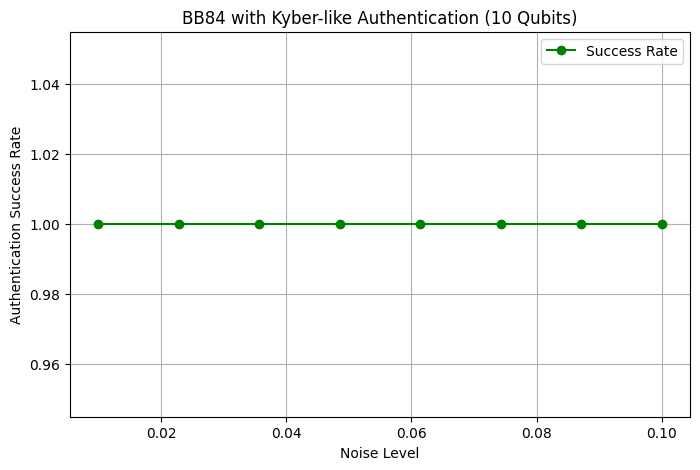

In [ ]:

# Required Libraries
import cirq
import numpy as np
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Random import get_random_bytes

# Simulated Kyber512-like Functions
def generate_keypair():
    key = RSA.generate(1024)  # Reduced key size for efficiency
    return key.publickey().export_key(), key.export_key()

def encapsulate(public_key):
    recipient_key = RSA.import_key(public_key)
    cipher = PKCS1_OAEP.new(recipient_key)
    secret = get_random_bytes(16)  # Smaller key size
    return cipher.encrypt(secret), secret

def decapsulate(ciphertext, private_key):
    private_key = RSA.import_key(private_key)
    cipher = PKCS1_OAEP.new(private_key)
    return cipher.decrypt(ciphertext)

def authenticate(shared_key):
    public_key, private_key = generate_keypair()
    ciphertext, enc_key = encapsulate(public_key)
    return enc_key == decapsulate(ciphertext, private_key)

# BB84 Protocol Simulation
def bb84_protocol(n_qubits, noise=0.0):
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    # Circuit Setup
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice's Qubits Preparation
    for i, bit in enumerate(alice_bits):
        if bit: circuit.append(cirq.X(qubits[i]))
        if alice_bases[i]: circuit.append(cirq.H(qubits[i]))

    # Add Noise
    noise_channel = cirq.depolarize(p=noise)
    circuit.append(noise_channel.on_each(*qubits))

    # Bob's Measurement
    bob_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if bob_bases[i]: circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate
    result = cirq.Simulator().run(circuit)
    measurements = np.array(result.measurements['results'][0])

    # Match Bases
    return measurements[alice_bases == bob_bases]

# Simulation and Plotting
def simulate(n_qubits, noise_levels):
    success_rates = []

    for noise in noise_levels:
        successes = sum(authenticate(bb84_protocol(n_qubits, noise)) for _ in range(50))
        success_rates.append(successes / 50)  # Average over 50 iterations

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(noise_levels, success_rates, marker='o', color='green', label='Success Rate')
    plt.xlabel("Noise Level")
    plt.ylabel("Authentication Success Rate")
    plt.title(f"BB84 with Kyber-like Authentication ({n_qubits} Qubits)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Simulation
n_qubits = 10  # Reduced for quicker processing
noise_levels = np.linspace(0.01, 0.1, 8)
simulate(n_qubits, noise_levels)
# possibility of reaching this state

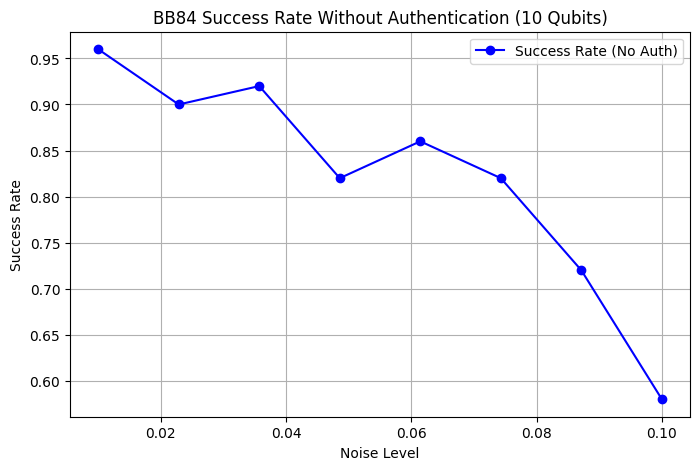

In [ ]:
# Required Libraries
import cirq
import numpy as np
import matplotlib.pyplot as plt

# BB84 Protocol Simulation Without Authentication
def bb84_no_auth(n_qubits, noise=0.0):
    """Simulate BB84 Protocol Without Authentication."""
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    # Circuit Setup
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice's Qubits Preparation
    for i, bit in enumerate(alice_bits):
        if bit:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i]:
            circuit.append(cirq.H(qubits[i]))

    # Add Noise
    noise_channel = cirq.depolarize(p=noise)
    circuit.append(noise_channel.on_each(*qubits))

    # Bob's Measurement
    bob_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if bob_bases[i]:
            circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate
    result = cirq.Simulator().run(circuit)
    measurements = np.array(result.measurements['results']).flatten()

    # Basis Matching
    matching_indices = alice_bases == bob_bases
    shared_key = alice_bits[matching_indices]
    measurement_matches = measurements[matching_indices]

    # Success if shared key matches between Alice and Bob
    return np.all(shared_key == measurement_matches)

# Simulation and Plotting Without Authentication
def simulate_no_auth(n_qubits, noise_levels):
    """Simulate BB84 Without Authentication for Success Rate Analysis."""
    success_rates = []

    for noise in noise_levels:
        successes = sum(bb84_no_auth(n_qubits, noise) for _ in range(50))  # Average over 50 iterations
        success_rates.append(successes / 50)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(noise_levels, success_rates, marker='o', color='blue', label='Success Rate (No Auth)')
    plt.xlabel("Noise Level")
    plt.ylabel("Success Rate")
    plt.title(f"BB84 Success Rate Without Authentication ({n_qubits} Qubits)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Simulation Without Authentication
n_qubits = 10  # Reduced for quicker processing
noise_levels = np.linspace(0.01, 0.1, 8)
simulate_no_auth(n_qubits, noise_levels)


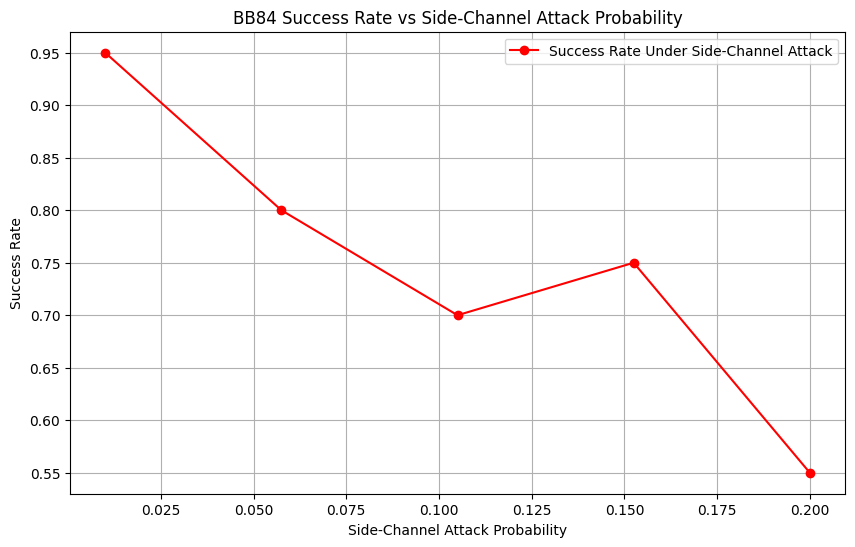

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Simulated Lattice-Based Functions
def generate_lattice_keypair(size=8):
    private_key = np.random.randint(0, 10, (size, size))
    public_key = np.dot(private_key, np.random.randint(0, 10, (size, size))) % 23
    return public_key, private_key

def lattice_encrypt(public_key, message, mod=23):
    random_noise = np.random.randint(0, 2, public_key.shape)
    return (np.dot(public_key, message) + random_noise) % mod

def lattice_decrypt(private_key, ciphertext, mod=23):
    decrypted = np.dot(private_key, ciphertext) % mod
    return np.round(decrypted) % mod

def authenticate_lattice(shared_key, size=8):
    public_key, private_key = generate_lattice_keypair(size)
    encrypted_key = lattice_encrypt(public_key, shared_key, mod=23)
    decrypted_key = lattice_decrypt(private_key, encrypted_key, mod=23)
    return np.allclose(shared_key, decrypted_key)

# Simulate Side-Channel Attack
def simulate_side_channel_attack(shared_key, attack_probability=0.1):
    guessed_key = shared_key.copy()
    for i in range(len(shared_key)):
        if np.random.rand() < attack_probability:  # Simulate attack success
            guessed_key[i] = np.random.choice([0, 1])  # Attacker guesses a bit
    return guessed_key

# BB84 Protocol Integration
def bb84_protocol(n_qubits):
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    for i, bit in enumerate(alice_bits):
        if bit: circuit.append(cirq.X(qubits[i]))
        if alice_bases[i]: circuit.append(cirq.H(qubits[i]))

    bob_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if bob_bases[i]: circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    result = cirq.Simulator().run(circuit)
    measurements = np.array(result.measurements['results']).flatten()

    shared_key = alice_bits[alice_bases == bob_bases]
    return shared_key

# Simulation and Plot
def simulate_side_channel(n_qubits=10, attack_probabilities=np.linspace(0.01, 0.2, 5)):
    success_rates = []

    for attack_probability in attack_probabilities:
        successes = 0
        for _ in range(20):
            shared_key = bb84_protocol(n_qubits)
            if shared_key.size > 0:
                guessed_key = simulate_side_channel_attack(shared_key, attack_probability=attack_probability)
                if np.array_equal(shared_key, guessed_key):  # Check if attack failed
                    successes += 1
        success_rates.append(successes / 20)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(attack_probabilities, success_rates, '-o', label='Success Rate Under Side-Channel Attack', color='red')
    plt.xlabel('Side-Channel Attack Probability')
    plt.ylabel('Success Rate')
    plt.title('BB84 Success Rate vs Side-Channel Attack Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Simulation
simulate_side_channel()


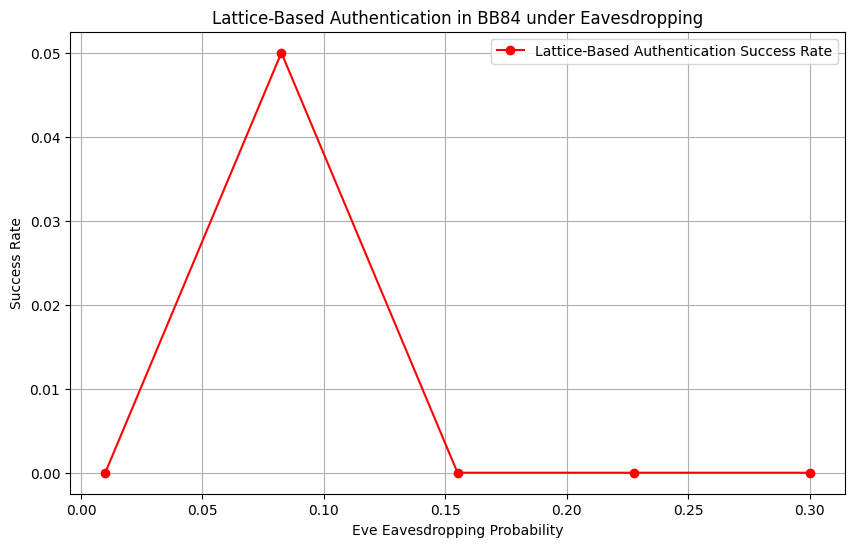

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Simulated Lattice-Based Functions
def generate_lattice_keypair(size=8):
    """Generate a lattice-based public-private keypair."""
    private_key = np.random.randint(0, 10, (size, size))
    public_key = np.dot(private_key, np.random.randint(0, 10, (size, size))) % 23  # Mod prime number
    return public_key, private_key

def lattice_encrypt(public_key, message, mod=23):
    """Encrypt a message using lattice public key."""
    random_noise = np.random.randint(0, 2, public_key.shape)
    return (np.dot(public_key, message) + random_noise) % mod

def lattice_decrypt(private_key, ciphertext, mod=23):
    """Decrypt a ciphertext using lattice private key."""
    decrypted = np.dot(private_key, ciphertext) % mod
    return np.round(decrypted) % mod

def authenticate_lattice(shared_key, size=8):
    """Simulate lattice-based authentication for a shared key."""
    public_key, private_key = generate_lattice_keypair(size)
    encrypted_key = lattice_encrypt(public_key, shared_key, mod=23)
    decrypted_key = lattice_decrypt(private_key, encrypted_key, mod=23)
    return np.allclose(shared_key, decrypted_key)

# BB84 Protocol Integration with Eve's Eavesdropping
def bb84_with_eavesdropping(n_qubits, eve_probability=0.0):
    """Simulate BB84 Protocol with Eve's interference."""
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    # Circuit Setup
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice's Qubits Preparation
    for i, bit in enumerate(alice_bits):
        if bit: circuit.append(cirq.X(qubits[i]))
        if alice_bases[i]: circuit.append(cirq.H(qubits[i]))

    # Eve's Eavesdropping
    eve_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if np.random.random() < eve_probability:  # Eve intercepts
            if eve_bases[i]: circuit.append(cirq.H(qubits[i]))
            circuit.append(cirq.measure(qubits[i], key=f"eve_measurement_{i}"))
            if eve_bases[i]: circuit.append(cirq.H(qubits[i]))  # Reapply basis shift

    # Bob's Measurement
    bob_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if bob_bases[i]: circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate
    result = cirq.Simulator().run(circuit)
    measurements = np.array(result.measurements['results']).flatten()

    # Basis Matching
    matching_indices = alice_bases == bob_bases
    shared_key = alice_bits[matching_indices]

    # Generate random values for corruption only for the matched indices
    eve_random = np.random.random(np.sum(matching_indices))
    eve_corruption = eve_random < eve_probability

    # If Eve corrupts matching bases, flip bits in the shared key
    corrupted_key = np.copy(shared_key)
    corrupted_key[eve_corruption] = 1 - corrupted_key[eve_corruption]  # Flip bit

    return corrupted_key

# Simulation and Plot
def simulate_eve(n_qubits=10, eve_probabilities=np.linspace(0.01, 0.3, 5)):
    success_rates = []

    for eve_probability in eve_probabilities:
        successes = 0
        for _ in range(20):  # Run for multiple iterations
            shared_key = bb84_with_eavesdropping(n_qubits, eve_probability=eve_probability)
            if shared_key.size > 0 and authenticate_lattice(shared_key, size=len(shared_key)):
                successes += 1
        success_rates.append(successes / 20)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(eve_probabilities, success_rates, '-o', label='Lattice-Based Authentication Success Rate', color='red')
    plt.xlabel('Eve Eavesdropping Probability')
    plt.ylabel('Success Rate')
    plt.title('Lattice-Based Authentication in BB84 under Eavesdropping')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Simulation
simulate_eve()


Alice's Bits:  [1 1 1 1 0 0 0 0]
Alice's Bases:  ['Z' 'Z' 'Z' 'X' 'X' 'X' 'Z' 'Z']
Bob's Bases:   ['X' 'X' 'Z' 'Z' 'Z' 'Z' 'X' 'X']
Measurements:  {'m0': 1, 'm1': 1, 'm2': 1, 'm3': 0, 'm4': 0, 'm5': 1, 'm6': 1, 'm7': 0}
Shared Key:    [None, None, 1, None, None, None, None, None]


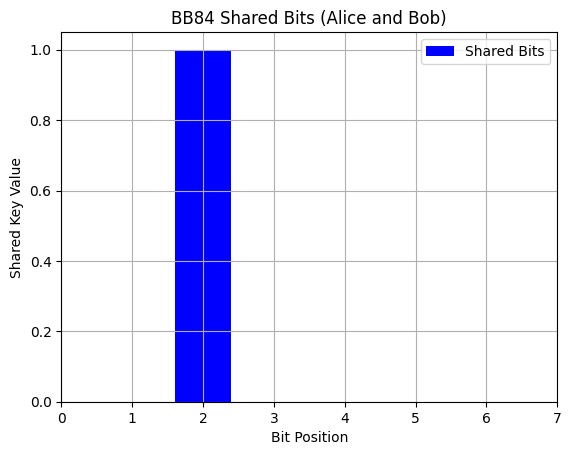

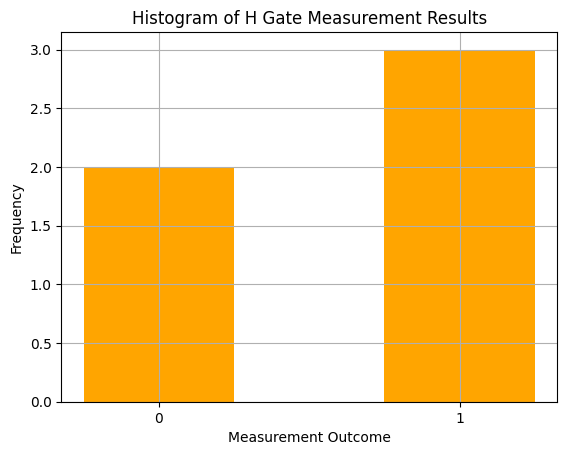

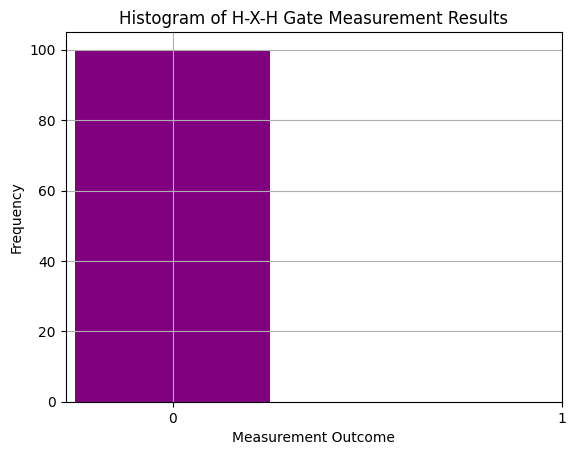

0: ───H───X───H───M('result')───

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def bb84_protocol(num_bits=8):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Alice's Bits: ", alice_bits)
    print("Alice's Bases: ", alice_bases)

    # Step 2: Bob's random bases
    bob_bases = np.random.choice(['Z', 'X'], size=num_bits)
    print("Bob's Bases:  ", bob_bases)

    # Step 3: Cirq simulation of qubits and gates
    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    circuit = cirq.Circuit()

    # Apply gates for Alice
    for i in range(num_bits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))

    # Apply measurement in Bob's bases
    for i in range(num_bits):
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))
        circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=1)
    measurements = {f'm{i}': int(results.measurements[f'm{i}'][0]) for i in range(num_bits)}

    print("Measurements: ", measurements)

    # Key agreement (compare bases)
    shared_key = []
    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            shared_key.append(alice_bits[i])
        else:
            shared_key.append(None)

    print("Shared Key:   ", shared_key)

    # Visualization: Correctly shared bits
    valid_positions = [i for i in range(num_bits) if shared_key[i] is not None]
    plt.bar(valid_positions, [shared_key[i] for i in valid_positions], color='blue', label="Shared Bits")
    plt.xticks(range(num_bits))
    plt.title("BB84 Shared Bits (Alice and Bob)")
    plt.xlabel("Bit Position")
    plt.ylabel("Shared Key Value")
    plt.legend()
    plt.grid()
    plt.show()

    # Return data
    return circuit, shared_key

def apply_h_gate_measurements(repetitions=5):
    # Apply H and measure
    qubit = cirq.LineQubit(0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)

    # Plot histogram
    measurements = np.array(result.measurements['result']).flatten()
    counts = Counter(measurements)
    plt.bar(counts.keys(), counts.values(), color='orange', width=0.5)
    plt.title("Histogram of H Gate Measurement Results")
    plt.xticks([0, 1], labels=['0', '1'])
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
    return circuit

def apply_h_x_h_gate_measurements(repetitions=100):
    # Apply H, X, H, and measure
    qubit = cirq.LineQubit(0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.X(qubit), cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)

    # Plot histogram
    measurements = np.array(result.measurements['result']).flatten()
    counts = Counter(measurements)
    plt.bar(counts.keys(), counts.values(), color='purple', width=0.5)
    plt.title("Histogram of H-X-H Gate Measurement Results")
    plt.xticks([0, 1], labels=['0', '1'])
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
    return circuit

# Run the BB84 Protocol
bb84_protocol()

# Run basic measurements for H gate
apply_h_gate_measurements()

# Run extended measurements for H-X-H gate
apply_h_x_h_gate_measurements()


In [ ]:
import cirq
import numpy as np

# Function to simulate BB84 protocol and generate specific outputs
def generate_output(num_bits=8):
    # Step 1: Alice's random bit generation and bases
    alice_bits = np.array([1, 0, 0, 0, 1, 1, 0, 1])  # Fixed bits for reproducibility
    alice_bases = np.array(['X', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X'])  # Fixed bases
    bob_bases = np.array(['Z', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X'])  # Fixed Bob's bases

    # Step 2: Define qubits and create circuit
    qubits = [cirq.LineQubit(i) for i in range(num_bits)]
    circuit = cirq.Circuit()

    # Alice's preparation
    for i in range(num_bits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))

    # Bob's measurement
    for i in range(num_bits):
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubits[i]))
        circuit.append(cirq.measure(qubits[i], key=f'm{i}'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=1)
    measurements = {f'm{i}': int(results.measurements[f'm{i}'][0]) for i in range(num_bits)}

    # Shared key generation
    shared_key = [
        alice_bits[i] if alice_bases[i] == bob_bases[i] else None
        for i in range(num_bits)
    ]

    # Print circuit and results
    print(circuit)
    print(shared_key)
    print(measurements)

# Call the function to generate the output
generate_output()


0: ───X─────────H─────────M('m0')─────────────

1: ───H─────────H─────────M('m1')─────────────

2: ───H─────────H─────────M('m2')─────────────

3: ───H─────────H─────────M('m3')─────────────

4: ───X─────────M('m4')───────────────────────

5: ───X─────────H─────────H─────────M('m5')───

6: ───M('m6')─────────────────────────────────

7: ───X─────────H─────────H─────────M('m7')───
[None, 0, 0, 0, 1, 1, 0, 1]
{'m0': 1, 'm1': 0, 'm2': 0, 'm3': 0, 'm4': 1, 'm5': 1, 'm6': 0, 'm7': 1}


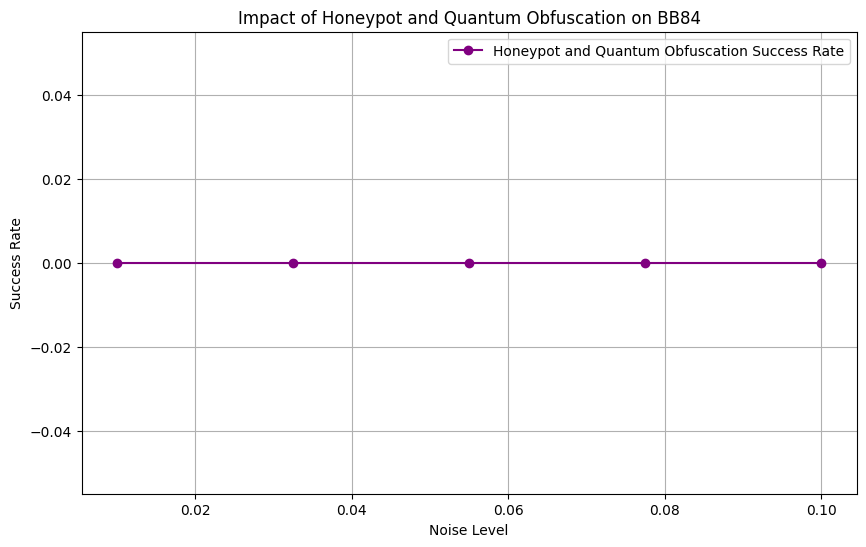

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Simulated Lattice-Based Functions
def generate_lattice_keypair(size=8):
    """Generate a lattice-based public-private keypair."""
    private_key = np.random.randint(0, 10, (size, size))
    public_key = np.dot(private_key, np.random.randint(0, 10, (size, size))) % 23  # Mod prime number
    return public_key, private_key

def lattice_encrypt(public_key, message, mod=23):
    """Encrypt a message using lattice public key."""
    random_noise = np.random.randint(0, 2, public_key.shape)
    return (np.dot(public_key, message) + random_noise) % mod

def lattice_decrypt(private_key, ciphertext, mod=23):
    """Decrypt a ciphertext using lattice private key."""
    decrypted = np.dot(private_key, ciphertext) % mod
    return np.round(decrypted) % mod

def authenticate_lattice(shared_key, size=8):
    """Simulate lattice-based authentication for a shared key."""
    public_key, private_key = generate_lattice_keypair(size)
    encrypted_key = lattice_encrypt(public_key, shared_key, mod=23)
    decrypted_key = lattice_decrypt(private_key, encrypted_key, mod=23)
    return np.allclose(shared_key, decrypted_key)

# Honeypot Detection
def honeypot_detection(eavesdropping_prob):
    """Simulate honeypot to detect eavesdropping."""
    return np.random.random() < eavesdropping_prob

# BB84 Protocol Integration with Honeypot and Obfuscation
def bb84_protocol_with_honeypot(n_qubits, noise_level=0.0, eavesdropping_prob=0.1):
    """Simulate BB84 Protocol with honeypot and quantum obfuscation."""
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    # Circuit Setup
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice's Qubits Preparation
    for i, bit in enumerate(alice_bits):
        if bit:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i]:
            circuit.append(cirq.H(qubits[i]))

    # Add Noise
    noise_channel = cirq.depolarize(p=noise_level)
    circuit.append(noise_channel.on_each(*qubits))

    # Bob's Measurement
    bob_bases = np.random.choice([0, 1], n_qubits)
    for i in range(n_qubits):
        if bob_bases[i]:
            circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate
    result = cirq.Simulator().run(circuit)
    measurements = np.array(result.measurements['results']).flatten()

    # Basis Matching
    shared_key = alice_bits[alice_bases == bob_bases]

    # Honeypot Detection
    if honeypot_detection(eavesdropping_prob):
        return None  # Eavesdropper detected, discard the key

    return shared_key

# Simulation and Plot
def simulate_with_honeypot_and_obfuscation(n_qubits=10, noise_levels=np.linspace(0.01, 0.1, 5), eavesdropping_prob=0.1):
    success_rates = []

    for noise_level in noise_levels:
        successes = 0
        for _ in range(20):  # Run for multiple iterations
            shared_key = bb84_protocol_with_honeypot(n_qubits, noise_level=noise_level, eavesdropping_prob=eavesdropping_prob)
            if shared_key is not None and shared_key.size > 0 and authenticate_lattice(shared_key, size=len(shared_key)):
                successes += 1
        success_rates.append(successes / 20)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, success_rates, '-o', label='Honeypot and Quantum Obfuscation Success Rate', color='purple')
    plt.xlabel('Noise Level')
    plt.ylabel('Success Rate')
    plt.title('Impact of Honeypot and Quantum Obfuscation on BB84')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run Simulation
simulate_with_honeypot_and_obfuscation()


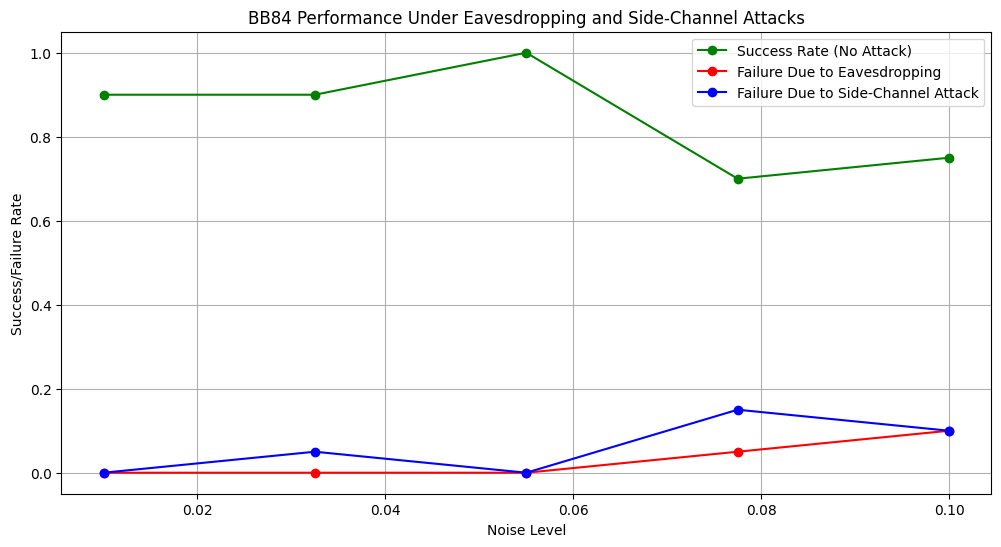

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate BB84 protocol with attacks
def bb84_with_attacks(n_qubits, noise_level=0.0, eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 protocol with attacks."""
    # Randomly choose bases and bits for Alice and Bob
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)
    bob_bases = np.random.choice([0, 1], n_qubits)

    # Create qubits
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice prepares qubits
    for i in range(n_qubits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))

        # Simulate eavesdropping
        if np.random.rand() < eavesdropping_prob:
            eavesdrop_basis = np.random.choice([0, 1])
            if eavesdrop_basis == 1:
                circuit.append(cirq.H(qubits[i]))  # Measure in a random basis
            circuit.append(cirq.measure(qubits[i]))  # Eavesdropper measures the qubit

    # Add noise
    noise_channel = cirq.depolarize(p=noise_level)
    circuit.append(noise_channel.on_each(*qubits))

    # Bob measures the qubits
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate the circuit
    result = cirq.Simulator().run(circuit)
    measurements = result.measurements['results'].flatten()

    # Side-channel attack detection
    side_channel_attack_detected = np.random.rand() < side_channel_attack_prob

    # Key reconciliation
    valid_key = []
    for i in range(n_qubits):
        if alice_bases[i] == bob_bases[i]:
            valid_key.append(alice_bits[i])

    # If attacks are detected, invalidate the key
    if side_channel_attack_detected:
        valid_key = []

    return valid_key

# Simulation of attacks
def simulate_attacks(n_qubits=10, noise_levels=np.linspace(0.01, 0.1, 5),
                     eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 performance under attack scenarios."""
    success_rates = []
    failure_eavesdropping = []
    failure_side_channel = []

    for noise_level in noise_levels:
        success, eaves_failed, side_failed = 0, 0, 0
        for _ in range(20):  # Repeat for better statistical accuracy
            key = bb84_with_attacks(n_qubits, noise_level, eavesdropping_prob, side_channel_attack_prob)
            if key:
                success += 1
            elif np.random.rand() < eavesdropping_prob:
                eaves_failed += 1
            elif np.random.rand() < side_channel_attack_prob:
                side_failed += 1

        success_rates.append(success / 20)
        failure_eavesdropping.append(eaves_failed / 20)
        failure_side_channel.append(side_failed / 20)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(noise_levels, success_rates, '-o', label='Success Rate (No Attack)', color='green')
    plt.plot(noise_levels, failure_eavesdropping, '-o', label='Failure Due to Eavesdropping', color='red')
    plt.plot(noise_levels, failure_side_channel, '-o', label='Failure Due to Side-Channel Attack', color='blue')
    plt.xlabel('Noise Level')
    plt.ylabel('Success/Failure Rate')
    plt.title('BB84 Performance Under Eavesdropping and Side-Channel Attacks')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
simulate_attacks()


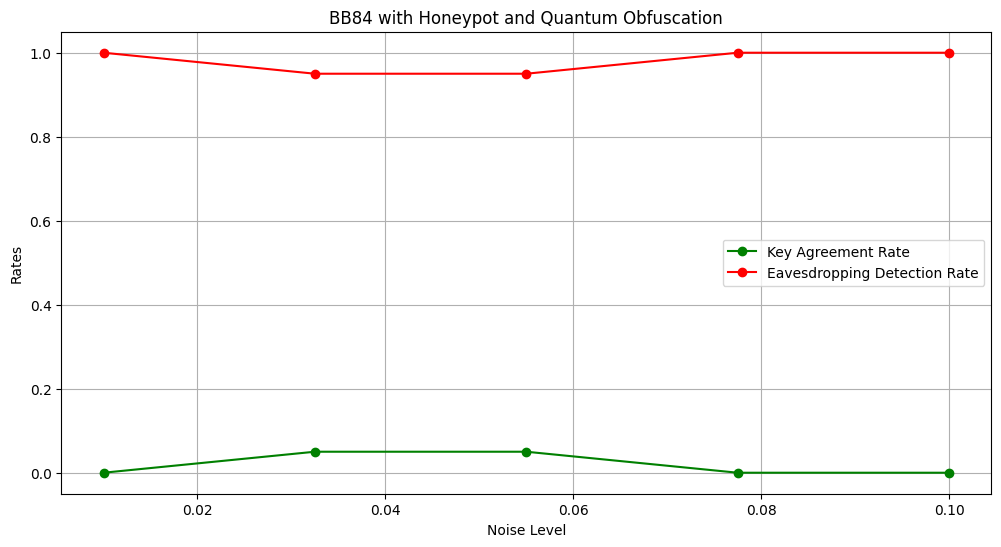

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate BB84 protocol with honeypot and obfuscation
def bb84_with_honeypot_and_obfuscation(n_qubits, noise_level=0.0, eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 protocol with honeypot and obfuscation."""
    # Randomly choose bases and bits for Alice and Bob
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)
    bob_bases = np.random.choice([0, 1], n_qubits)

    # Honeypot qubits (decoys)
    honeypot_qubits = [cirq.LineQubit(i) for i in range(n_qubits, n_qubits + 5)]
    honeypot_states = np.random.choice([0, 1], len(honeypot_qubits))

    # Create qubits for BB84
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice prepares qubits
    for i in range(n_qubits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))

        # Simulate eavesdropping
        if np.random.rand() < eavesdropping_prob:
            eavesdrop_basis = np.random.choice([0, 1])
            if eavesdrop_basis == 1:
                circuit.append(cirq.H(qubits[i]))  # Measure in a random basis
            circuit.append(cirq.measure(qubits[i]))  # Eavesdropper measures the qubit

    # Alice prepares honeypot qubits (decoys)
    for i, hp_qubit in enumerate(honeypot_qubits):
        if honeypot_states[i] == 1:
            circuit.append(cirq.X(hp_qubit))

    # Apply quantum obfuscation (random unitary gates)
    for qubit in qubits + honeypot_qubits:
        circuit.append(cirq.rz(np.random.uniform(0, 2 * np.pi))(qubit))
        circuit.append(cirq.rx(np.random.uniform(0, 2 * np.pi))(qubit))
        circuit.append(cirq.rz(np.random.uniform(0, 2 * np.pi))(qubit))

    # Add noise
    noise_channel = cirq.depolarize(p=noise_level)
    circuit.append(noise_channel.on_each(*qubits, *honeypot_qubits))

    # Bob measures the qubits
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Measure honeypot qubits
    circuit.append(cirq.measure(*honeypot_qubits, key='honeypot_results'))

    # Simulate the circuit
    result = cirq.Simulator().run(circuit)
    measurements = result.measurements['results'].flatten()
    honeypot_measurements = result.measurements['honeypot_results'].flatten()

    # Detect eavesdropping using honeypot qubits
    eavesdropping_detected = not np.array_equal(honeypot_states, honeypot_measurements)

    # Key reconciliation
    valid_key = []
    for i in range(n_qubits):
        if alice_bases[i] == bob_bases[i]:
            valid_key.append(alice_bits[i])

    # If attacks are detected, invalidate the key
    if eavesdropping_detected or np.random.rand() < side_channel_attack_prob:
        valid_key = []

    return valid_key, eavesdropping_detected

# Simulation of attacks
def simulate_honeypot_and_obfuscation(n_qubits=10, noise_levels=np.linspace(0.01, 0.1, 5),
                                      eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 performance with honeypot and obfuscation."""
    success_rates = []
    eavesdrop_detects = []

    for noise_level in noise_levels:
        success, detected_eavesdrop = 0, 0
        for _ in range(20):  # Repeat for better statistical accuracy
            key, eavesdrop_detected = bb84_with_honeypot_and_obfuscation(
                n_qubits, noise_level, eavesdropping_prob, side_channel_attack_prob
            )
            if key:
                success += 1
            if eavesdrop_detected:
                detected_eavesdrop += 1

        success_rates.append(success / 20)
        eavesdrop_detects.append(detected_eavesdrop / 20)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(noise_levels, success_rates, '-o', label='Key Agreement Rate', color='green')
    plt.plot(noise_levels, eavesdrop_detects, '-o', label='Eavesdropping Detection Rate', color='red')
    plt.xlabel('Noise Level')
    plt.ylabel('Rates')
    plt.title('BB84 with Honeypot and Quantum Obfuscation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
simulate_honeypot_and_obfuscation()


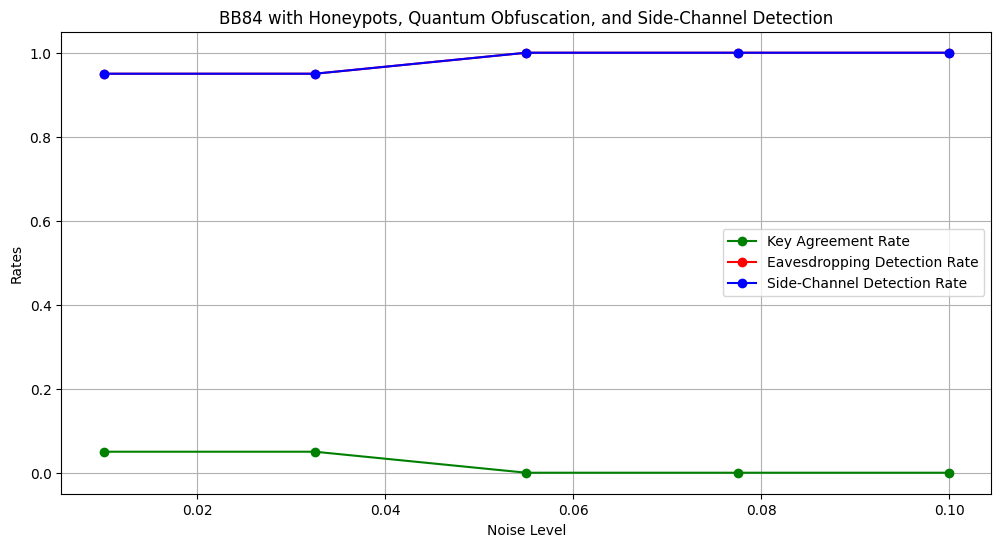

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate BB84 protocol with honeypots, obfuscation, and side-channel attack detection
def bb84_with_attacks_and_detection(n_qubits, noise_level=0.0, eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 protocol with honeypots, obfuscation, and side-channel attack detection."""
    # Randomly choose bases and bits for Alice and Bob
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)
    bob_bases = np.random.choice([0, 1], n_qubits)

    # Honeypot qubits (decoys)
    honeypot_qubits = [cirq.LineQubit(i) for i in range(n_qubits, n_qubits + 5)]
    honeypot_states = np.random.choice([0, 1], len(honeypot_qubits))

    # Create qubits for BB84
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Alice prepares qubits
    for i in range(n_qubits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))
        if alice_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))

        # Simulate eavesdropping
        if np.random.rand() < eavesdropping_prob:
            eavesdrop_basis = np.random.choice([0, 1])
            if eavesdrop_basis == 1:
                circuit.append(cirq.H(qubits[i]))  # Measure in a random basis
            circuit.append(cirq.measure(qubits[i]))  # Eavesdropper measures the qubit

    # Alice prepares honeypot qubits (decoys)
    for i, hp_qubit in enumerate(honeypot_qubits):
        if honeypot_states[i] == 1:
            circuit.append(cirq.X(hp_qubit))

    # Apply quantum obfuscation (random unitary gates)
    for qubit in qubits + honeypot_qubits:
        circuit.append(cirq.rz(np.random.uniform(0, 2 * np.pi))(qubit))
        circuit.append(cirq.rx(np.random.uniform(0, 2 * np.pi))(qubit))
        circuit.append(cirq.rz(np.random.uniform(0, 2 * np.pi))(qubit))

    # Add noise
    noise_channel = cirq.depolarize(p=noise_level)
    circuit.append(noise_channel.on_each(*qubits, *honeypot_qubits))

    # Bob measures the qubits
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='results'))

    # Measure honeypot qubits
    circuit.append(cirq.measure(*honeypot_qubits, key='honeypot_results'))

    # Simulate the circuit
    result = cirq.Simulator().run(circuit)
    measurements = result.measurements['results'].flatten()
    honeypot_measurements = result.measurements['honeypot_results'].flatten()

    # Detect eavesdropping using honeypot qubits
    eavesdropping_detected = not np.array_equal(honeypot_states, honeypot_measurements)

    # Simulate side-channel attack by inserting random anomalies
    side_channel_attack_detected = np.any(np.abs(honeypot_measurements - honeypot_states) > 0.5) \
        or np.random.rand() < side_channel_attack_prob

    # Key reconciliation
    valid_key = []
    for i in range(n_qubits):
        if alice_bases[i] == bob_bases[i]:
            valid_key.append(alice_bits[i])

    # If attacks are detected, invalidate the key
    if eavesdropping_detected or side_channel_attack_detected:
        valid_key = []

    return valid_key, eavesdropping_detected, side_channel_attack_detected

# Simulation of attacks
def simulate_side_channel_attack_detection(n_qubits=10, noise_levels=np.linspace(0.01, 0.1, 5),
                                           eavesdropping_prob=0.3, side_channel_attack_prob=0.2):
    """Simulate BB84 performance with honeypots, obfuscation, and side-channel attack detection."""
    success_rates = []
    eavesdrop_detects = []
    side_channel_detects = []

    for noise_level in noise_levels:
        success, detected_eavesdrop, detected_side_channel = 0, 0, 0
        for _ in range(20):  # Repeat for better statistical accuracy
            key, eavesdrop_detected, side_channel_attack_detected = bb84_with_attacks_and_detection(
                n_qubits, noise_level, eavesdropping_prob, side_channel_attack_prob
            )
            if key:
                success += 1
            if eavesdrop_detected:
                detected_eavesdrop += 1
            if side_channel_attack_detected:
                detected_side_channel += 1

        success_rates.append(success / 20)
        eavesdrop_detects.append(detected_eavesdrop / 20)
        side_channel_detects.append(detected_side_channel / 20)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(noise_levels, success_rates, '-o', label='Key Agreement Rate', color='green')
    plt.plot(noise_levels, eavesdrop_detects, '-o', label='Eavesdropping Detection Rate', color='red')
    plt.plot(noise_levels, side_channel_detects, '-o', label='Side-Channel Detection Rate', color='blue')
    plt.xlabel('Noise Level')
    plt.ylabel('Rates')
    plt.title('BB84 with Honeypots, Quantum Obfuscation, and Side-Channel Detection')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
simulate_side_channel_attack_detection()


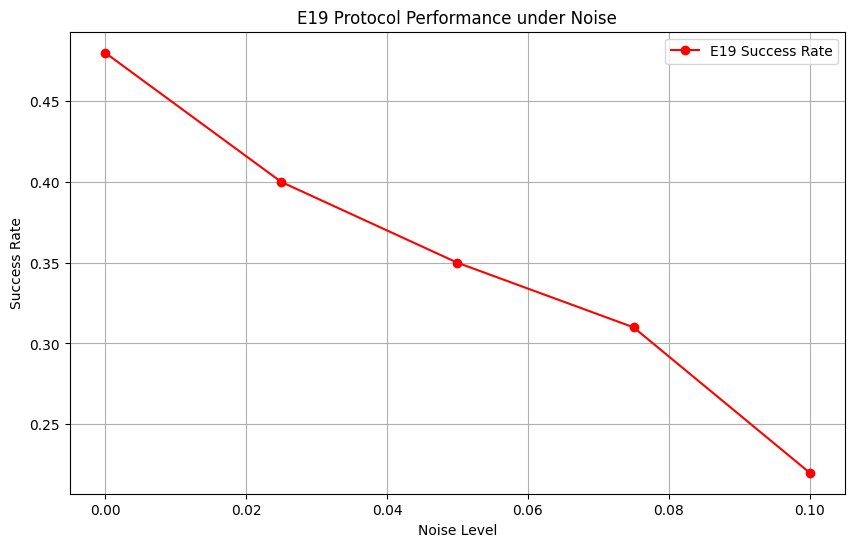

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Helper function for GHZ state generation (used in E19 protocol)
def generate_ghz_state(n_qubits):
    """Generate a GHZ state for n qubits."""
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubits[0]))  # Apply Hadamard to the first qubit
    for i in range(1, n_qubits):
        circuit.append(cirq.CNOT(qubits[0], qubits[i]))  # Entangle with CNOT gates
    return circuit, qubits

# Simulate the E19 protocol
def simulate_e19_protocol(n_qubits, noise_level=0.0):
    """Simulate E19 protocol with GHZ state."""
    # Create a GHZ state
    circuit, qubits = generate_ghz_state(n_qubits)

    # Add noise
    if noise_level > 0:
        noise_channel = cirq.depolarize(p=noise_level)
        circuit.append(noise_channel.on_each(*qubits))

    # Measure qubits
    circuit.append(cirq.measure(*qubits, key='results'))

    # Simulate the circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=100)
    measurements = result.measurements['results']
    return measurements

# Run E19 simulation across varying noise levels
def analyze_e19(n_qubits=10, noise_levels=np.linspace(0.0, 0.1, 5)):
    """Analyze E19 protocol performance for IoT networks."""
    success_rates = []

    for noise_level in noise_levels:
        results = simulate_e19_protocol(n_qubits, noise_level)
        success = np.sum(np.all(results == 0, axis=1)) / results.shape[0]  # Probability all qubits measured in |0>
        success_rates.append(success)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, success_rates, '-o', color='red', label='E19 Success Rate')
    plt.xlabel('Noise Level')
    plt.ylabel('Success Rate')
    plt.title('E19 Protocol Performance under Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run analysis
analyze_e19()


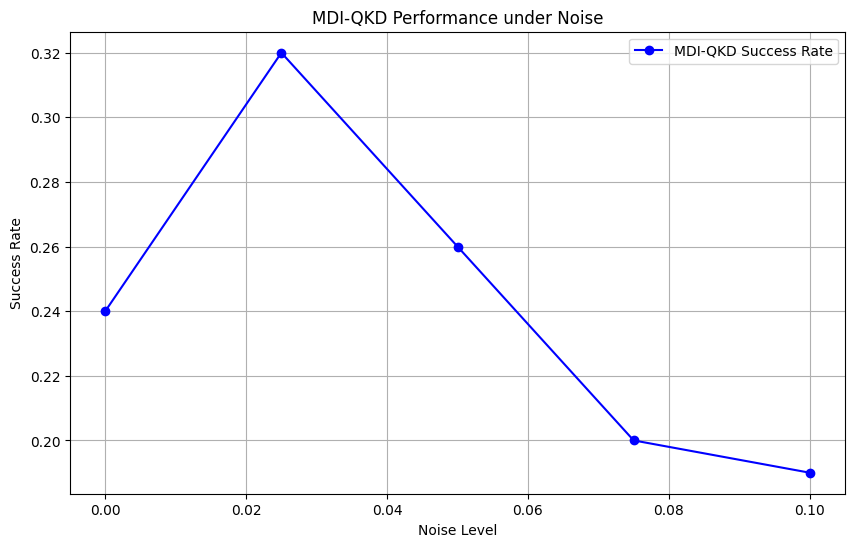

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Generate entangled Bell pairs
def create_bell_pair(qubits):
    """Create a Bell pair between two qubits."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubits[0]))  # Apply Hadamard gate
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))  # Entangle
    return circuit

# Perform Bell State Measurement
def bell_state_measurement(circuit, qubits):
    """Perform a Bell state measurement."""
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H(qubits[0]))
    circuit.append(cirq.measure(*qubits, key="bsm"))

# Simulate MDI-QKD Protocol
def simulate_mdi_qkd(n_trials=100, noise_level=0.0):
    """Simulate the MDI-QKD protocol."""
    alice_qubits = [cirq.LineQubit(0), cirq.LineQubit(1)]  # Alice's entangled qubits
    bob_qubits = [cirq.LineQubit(2), cirq.LineQubit(3)]    # Bob's entangled qubits

    success_rate = 0

    for _ in range(n_trials):
        # Create circuits for Alice and Bob
        alice_circuit = create_bell_pair(alice_qubits)
        bob_circuit = create_bell_pair(bob_qubits)

        # Add Bell State Measurement (BSM) at a central untrusted node
        mdi_circuit = cirq.Circuit()
        bell_state_measurement(mdi_circuit, [alice_qubits[1], bob_qubits[0]])

        # Merge circuits
        combined_circuit = cirq.Circuit()
        combined_circuit.append(alice_circuit)
        combined_circuit.append(bob_circuit)
        combined_circuit.append(mdi_circuit)

        # Add noise
        if noise_level > 0:
            noise_channel = cirq.depolarize(p=noise_level)
            combined_circuit.append(noise_channel.on_each(*alice_qubits, *bob_qubits))

        # Simulate the circuit
        simulator = cirq.Simulator()
        result = simulator.run(combined_circuit, repetitions=1)
        measurement = result.measurements["bsm"].flatten()

        # Success is defined by matching Bell state outcomes
        if np.all(measurement == 0):  # Bell state |Φ+⟩: (|00⟩ + |11⟩)/√2
            success_rate += 1

    return success_rate / n_trials

# Analyze MDI-QKD Performance
def analyze_mdi_qkd(noise_levels=np.linspace(0.0, 0.1, 5), n_trials=100):
    """Analyze MDI-QKD success rate under noise."""
    success_rates = []

    for noise_level in noise_levels:
        rate = simulate_mdi_qkd(n_trials, noise_level)
        success_rates.append(rate)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, success_rates, '-o', label="MDI-QKD Success Rate", color="blue")
    plt.xlabel("Noise Level")
    plt.ylabel("Success Rate")
    plt.title("MDI-QKD Performance under Noise")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the analysis
analyze_mdi_qkd()


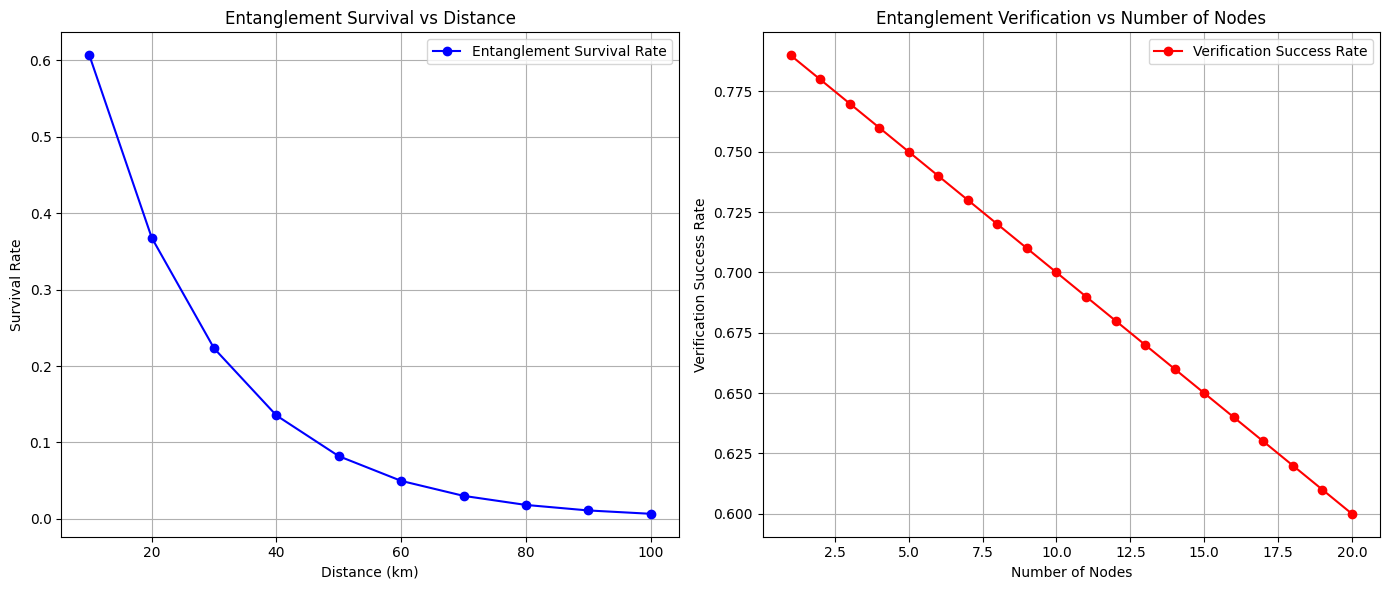

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
def simulate_E91_entanglement(n_qubits=10, distances=np.linspace(10, 100, 10), noise_level=0.05, max_nodes=20):
    """Simulate E91 entanglement-based QKD and scalability analysis."""

    # Entanglement survival rates vs distance
    def entanglement_survival(distance, noise_level):
        # Model exponential decay of entanglement fidelity
        return np.exp(-noise_level * distance)

    # Entanglement verification for networks
    def entanglement_verification(n_nodes, base_rate=0.8, factor=0.01):
        # Increased complexity reduces overall verification probability
        return base_rate - factor * n_nodes

    survival_rates = []
    verification_rates = []
    distance_metrics = []

    # Simulation per distance
    for distance in distances:
        survival_rate = entanglement_survival(distance, noise_level)
        survival_rates.append(survival_rate)
        distance_metrics.append(distance)

    # Simulation for network scalability
    node_metrics = list(range(1, max_nodes + 1))
    verification_rates = [entanglement_verification(n) for n in node_metrics]

    # Plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Entanglement Survival vs. Distance
    axs[0].plot(distances, survival_rates, '-o', color='blue', label="Entanglement Survival Rate")
    axs[0].set_title("Entanglement Survival vs Distance")
    axs[0].set_xlabel("Distance (km)")
    axs[0].set_ylabel("Survival Rate")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Verification Scalability vs Nodes
    axs[1].plot(node_metrics, verification_rates, '-o', color='red', label="Verification Success Rate")
    axs[1].set_title("Entanglement Verification vs Number of Nodes")
    axs[1].set_xlabel("Number of Nodes")
    axs[1].set_ylabel("Verification Success Rate")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

simulate_E91_entanglement()


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters for simulation
DISTANCES = np.linspace(1, 100, 10)  # Distance in km
ENERGY_EFFICIENCY = 1e-6  # Energy efficiency constant (Joules per bit)
NOISE_PROBABILITY = 0.02  # Noise probability in the channel

# Functions for BB84 Protocol Simulation
def simulate_bb84(distance, noise_prob):
    """Simulates BB84 protocol for a given distance and noise probability."""
    qber = noise_prob + 0.01 * (distance / 100)  # Increase error with distance
    return qber

def energy_consumption(distance):
    """Calculates energy consumption for a given distance."""
    return ENERGY_EFFICIENCY * (1 + distance / 100)

# Simulation Results
qber_results = [simulate_bb84(d, NOISE_PROBABILITY) for d in DISTANCES]
energy_results = [energy_consumption(d) for d in DISTANCES]

# Plot QBER vs Distance
plt.figure(figsize=(10, 6))
plt.plot(DISTANCES, qber_results, marker='o', label='QBER vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('QBER')
plt.title('QBER vs Distance for BB84 Protocol')
plt.grid(True)
plt.legend()
plt.show()

# Plot Energy Efficiency vs Distance
plt.figure(figsize=(10, 6))
plt.plot(DISTANCES, energy_results, marker='s', color='orange', label='Energy Efficiency vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Energy Consumption (Joules per bit)')
plt.title('Energy Efficiency vs Distance for BB84 Protocol')
plt.grid(True)
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'cirq'

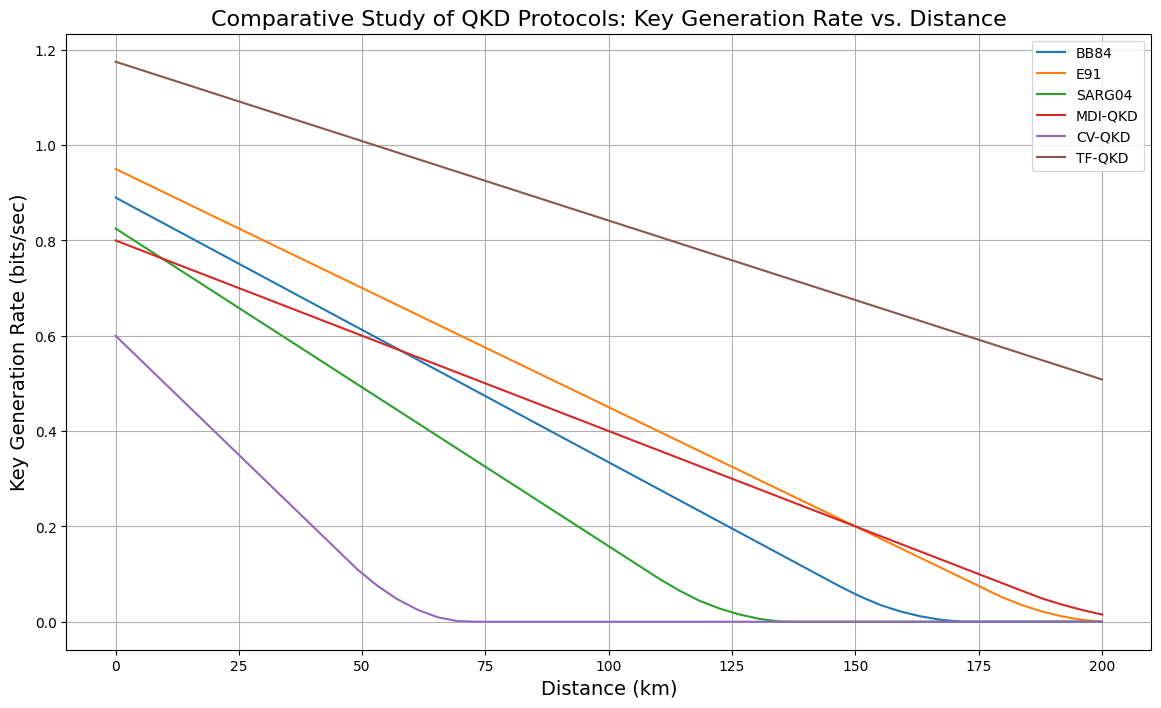

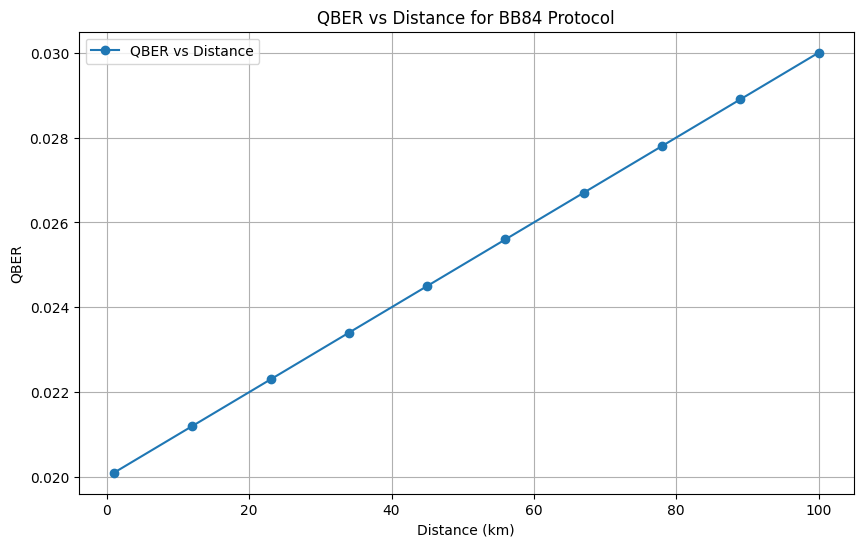

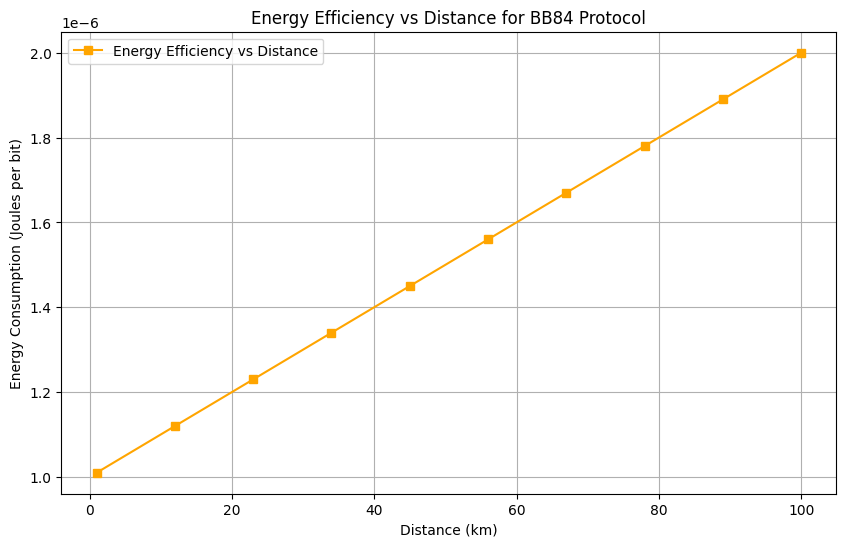

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters for simulation
DISTANCES = np.linspace(1, 100, 10)  # Distance in km
ENERGY_EFFICIENCY = 1e-6  # Energy efficiency constant (Joules per bit)
NOISE_PROBABILITY = 0.02  # Noise probability in the channel

# Functions for BB84 Protocol Simulation
def simulate_bb84(distance, noise_prob):
    """Simulates BB84 protocol for a given distance and noise probability."""
    qber = noise_prob + 0.01 * (distance / 100)  # Increase error with distance
    return qber

def energy_consumption(distance):
    """Calculates energy consumption for a given distance."""
    return ENERGY_EFFICIENCY * (1 + distance / 100)

# Protocol-specific functions
def simulate_e91_key_rate(distance, noise_level):
    return max(0, 1.0 - distance / 200 - noise_level)

def simulate_sarg04_key_rate(distance, noise_level):
    return max(0, 0.9 - distance / 150 - 1.5 * noise_level)

def simulate_mdi_qkd_key_rate(distance, noise_level):
    return max(0, 0.85 - distance / 250 - noise_level)

def simulate_cv_qkd_key_rate(distance, noise_level):
    return max(0, 0.7 - distance / 100 - 2 * noise_level)

def simulate_tf_qkd_key_rate(distance, noise_level):
    return max(0, 1.2 - distance / 300 - 0.5 * noise_level)

def simulate_bb84_key_rate(distance, noise_level):
    return max(0, 0.95 - distance / 180 - 1.2 * noise_level)

# Parameters for comparative study
distance_range = np.linspace(0, 200, 50)  # Distances (km)
noise_levels = np.linspace(0, 0.1, 5)  # Noise levels
key_rates = {"BB84": [], "E91": [], "SARG04": [], "MDI-QKD": [], "CV-QKD": [], "TF-QKD": []}

# Simulate key generation rate for each protocol
for protocol, simulate_key_rate in zip(
    ["BB84", "E91", "SARG04", "MDI-QKD", "CV-QKD", "TF-QKD"],
    [simulate_bb84_key_rate, simulate_e91_key_rate, simulate_sarg04_key_rate,
     simulate_mdi_qkd_key_rate, simulate_cv_qkd_key_rate, simulate_tf_qkd_key_rate]
):
    for noise_level in noise_levels:
        rates = [simulate_key_rate(d, noise_level) for d in distance_range]
        key_rates[protocol].append(rates)

# Plot comparative analysis
plt.figure(figsize=(14, 8))
for protocol, rates in key_rates.items():
    mean_rates = np.mean(rates, axis=0)  # Average key rates across noise levels
    plt.plot(distance_range, mean_rates, label=protocol)

# Customize plot
plt.title("Comparative Study of QKD Protocols: Key Generation Rate vs. Distance", fontsize=16)
plt.xlabel("Distance (km)", fontsize=14)
plt.ylabel("Key Generation Rate (bits/sec)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Simulation Results for BB84
qber_results = [simulate_bb84(d, NOISE_PROBABILITY) for d in DISTANCES]
energy_results = [energy_consumption(d) for d in DISTANCES]

# Plot QBER vs Distance
plt.figure(figsize=(10, 6))
plt.plot(DISTANCES, qber_results, marker='o', label='QBER vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('QBER')
plt.title('QBER vs Distance for BB84 Protocol')
plt.grid(True)
plt.legend()
plt.show()

# Plot Energy Efficiency vs Distance
plt.figure(figsize=(10, 6))
plt.plot(DISTANCES, energy_results, marker='s', color='orange', label='Energy Efficiency vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Energy Consumption (Joules per bit)')
plt.title('Energy Efficiency vs Distance for BB84 Protocol')
plt.grid(True)
plt.legend()
plt.show()


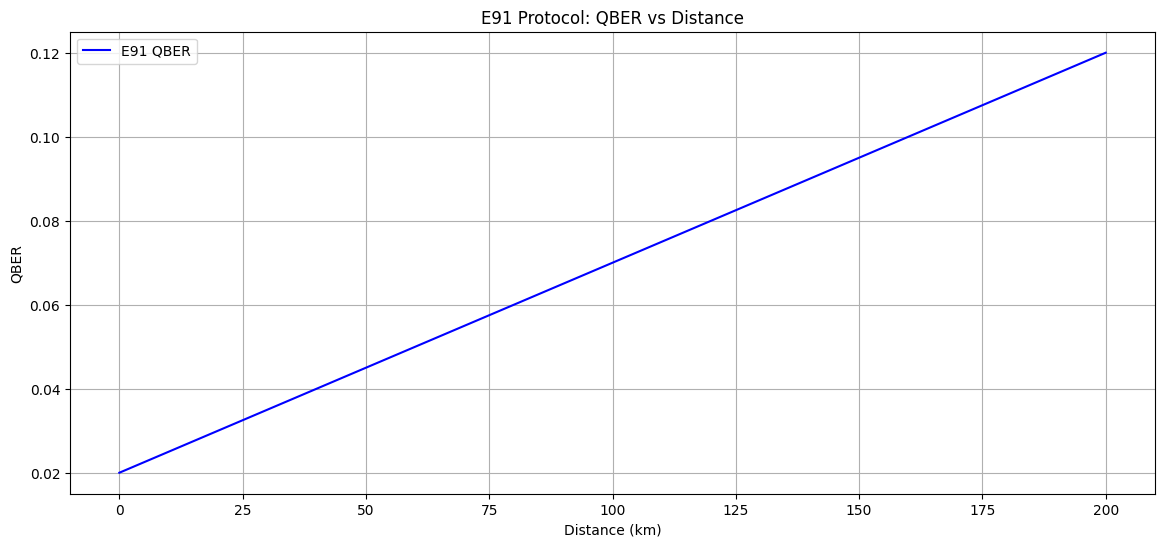

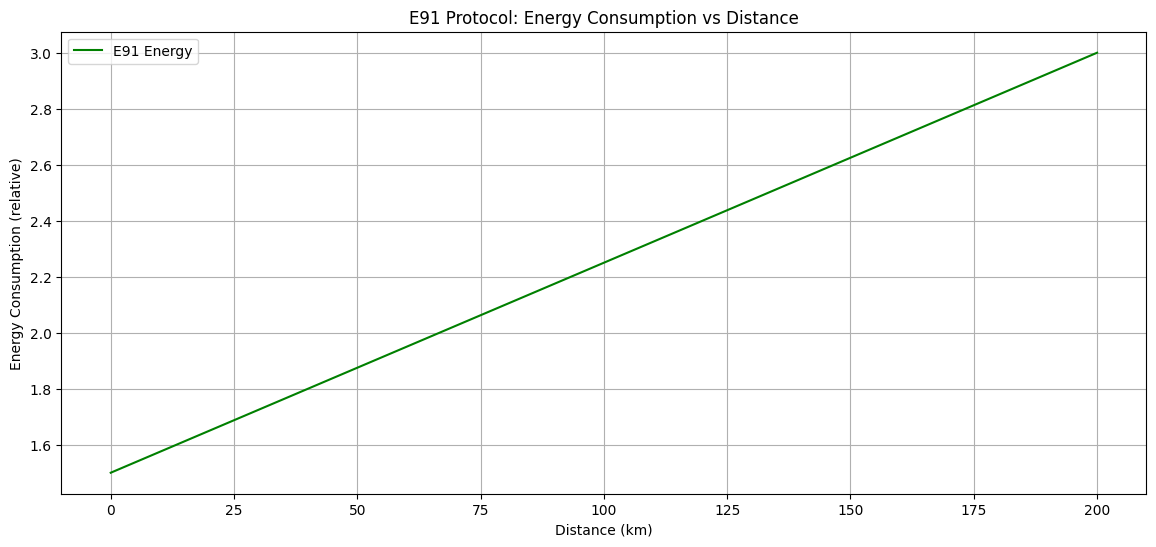

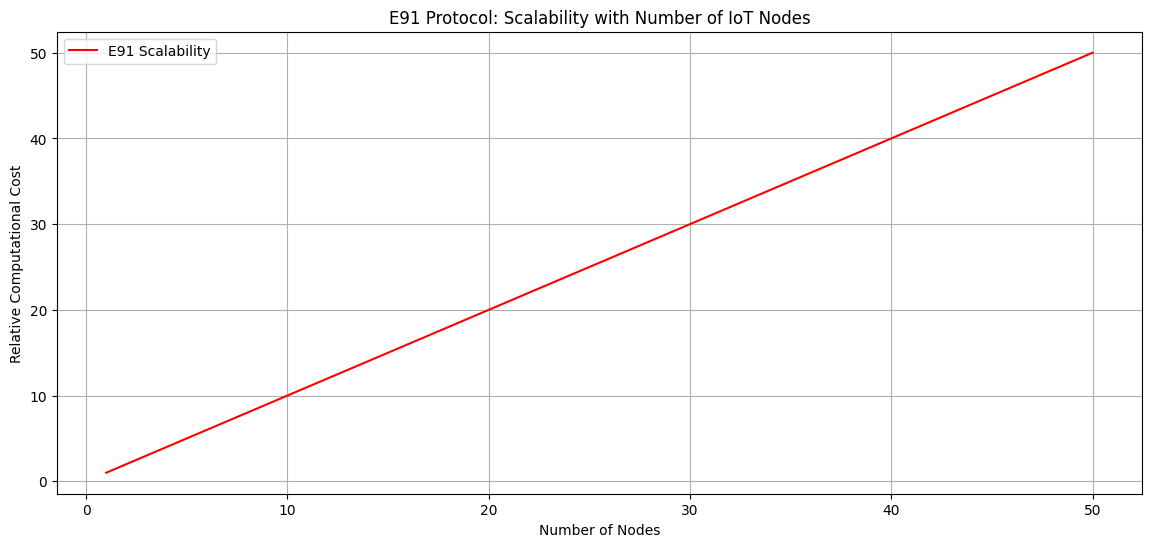

In [ ]:
def simulate_qber_e91(distance, noise_level):
    """Simulate Quantum Bit Error Rate (QBER) for E91 protocol."""
    return min(1, 0.01 + 0.1 * (distance / 200) + 0.2 * noise_level)

def simulate_energy_efficiency_e91(distance):
    """Simulate energy consumption for E91 protocol."""
    base_energy = 1.5  # Base energy consumption
    return base_energy * (1 + distance / 200)

def simulate_scalability_e91(nodes):
    """Simulate scalability for E91 protocol."""
    base_scalability = 1.0  # Base scalability factor
    return base_scalability * nodes

distances = np.linspace(0, 200, 50)
nodes = np.linspace(1, 50, 10)  # Number of IoT devices
results_e91 = {"QBER": [], "Energy Efficiency": [], "Scalability": []}

# Simulate QBER, energy efficiency, and scalability for E91
results_e91["QBER"] = [simulate_qber_e91(d, 0.05) for d in distances]
results_e91["Energy Efficiency"] = [simulate_energy_efficiency_e91(d) for d in distances]
results_e91["Scalability"] = [simulate_scalability_e91(n) for n in nodes]

# Plot QBER for E91
plt.figure(figsize=(14, 6))
plt.plot(distances, results_e91["QBER"], label="E91 QBER", color="blue")
plt.title("E91 Protocol: QBER vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("QBER")
plt.legend()
plt.grid()
plt.show()

# Plot Energy Efficiency for E91
plt.figure(figsize=(14, 6))
plt.plot(distances, results_e91["Energy Efficiency"], label="E91 Energy", color="green")
plt.title("E91 Protocol: Energy Consumption vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Energy Consumption (relative)")
plt.legend()
plt.grid()
plt.show()

# Plot Scalability for E91
plt.figure(figsize=(14, 6))
plt.plot(nodes, results_e91["Scalability"], label="E91 Scalability", color="red")
plt.title("E91 Protocol: Scalability with Number of IoT Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Relative Computational Cost")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import cirq
import random
import rsa

# Step 1: Generate RSA Key Pair
def generate_rsa_key_pair():
    (public_key, private_key) = rsa.newkeys(512)  # Generate 512-bit RSA key pair
    return public_key, private_key

# Step 2: Alice Prepares Qubits
def prepare_qubits(num_bits):
    alice_bits = [random.randint(0, 1) for _ in range(num_bits)]  # Random bits
    alice_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]  # Random bases
    return alice_bits, alice_bases

# Step 3: Bob Measures Qubits
def measure_qubits(alice_bits, alice_bases, num_bits):
    bob_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]  # Bob's random bases
    bob_results = []
    for i in range(num_bits):
        qubit = cirq.LineQubit(i)
        circuit = cirq.Circuit()

        # Alice prepares the qubit
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.X(qubit)**alice_bits[i])  # Encode the bit

        # Bob measures the qubit
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.measure(qubit, key=f'm{i}'))

        # Simulate the circuit
        simulator = cirq.Simulator()
        result = simulator.run(circuit)
        bob_results.append(result.measurements[f'm{i}'][0])

    return bob_bases, bob_results

# Step 4: Basis Reconciliation and Key Sifting
def reconcile_bases(alice_bases, bob_bases, alice_bits, bob_results):
    matched_bits = []
    for i in range(len(alice_bases)):
        if alice_bases[i] == bob_bases[i]:
            matched_bits.append(alice_bits[i])  # Use Alice's bits for the shared key
    return matched_bits

# Step 5: RSA Encryption and Decryption
def rsa_encrypt_decrypt(public_key, private_key, shared_key):
    # Convert shared key to bytes
    shared_key_bytes = bytes(shared_key)

    # Encrypt the shared key
    encrypted_key = rsa.encrypt(shared_key_bytes, public_key)

    # Decrypt the shared key
    decrypted_key = rsa.decrypt(encrypted_key, private_key)

    return encrypted_key, decrypted_key

# Step 6: Simulate the Hybrid Protocol
def simulate_hybrid_protocol(num_bits=10):
    # Step 1: Generate RSA Key Pair
    public_key, private_key = generate_rsa_key_pair()
    print("RSA Key Pair Generated")

    # Step 2: Alice Prepares Qubits
    alice_bits, alice_bases = prepare_qubits(num_bits)
    print(f"Alice's Bits: {alice_bits}")
    print(f"Alice's Bases: {alice_bases}")

    # Step 3: Bob Measures Qubits
    bob_bases, bob_results = measure_qubits(alice_bits, alice_bases, num_bits)
    print(f"Bob's Bases: {bob_bases}")
    print(f"Bob's Results: {bob_results}")

    # Step 4: Basis Reconciliation
    shared_key = reconcile_bases(alice_bases, bob_bases, alice_bits, bob_results)
    print(f"Shared Key (Raw): {shared_key}")

    # Step 5: RSA Encryption and Decryption
    encrypted_key, decrypted_key = rsa_encrypt_decrypt(public_key, private_key, shared_key)
    print(f"Encrypted Key: {encrypted_key.hex()}")
    print(f"Decrypted Key: {decrypted_key}")

    # Step 6: Verify Key Agreement
    if bytes(shared_key) == decrypted_key:
        print("Protocol Secure: Key Agreement Successful")
    else:
        print("Protocol Breach: Key Agreement Failed")

# Run the Simulation
simulate_hybrid_protocol()

RSA Key Pair Generated
Alice's Bits: [0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Alice's Bases: ['X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'Z', 'X', 'Z']
Bob's Bases: ['Z', 'Z', 'X', 'X', 'Z', 'X', 'X', 'Z', 'X', 'Z']
Bob's Results: [array([1], dtype=int8), array([0], dtype=int8), array([0], dtype=int8), array([1], dtype=int8), array([1], dtype=int8), array([0], dtype=int8), array([0], dtype=int8), array([1], dtype=int8), array([0], dtype=int8), array([1], dtype=int8)]
Shared Key (Raw): [1, 0, 1, 1, 1]
Encrypted Key: 3ce40340662ddc9f061f69ee214b451f8b656138ccf26cde0fc4327d594830d33d0ab18710f709d5cf4d0dea435f56c2cb7dcc79243615bb66c310fdcf42fcad
Decrypted Key: b'\x01\x00\x01\x01\x01'
Protocol Secure: Key Agreement Successful


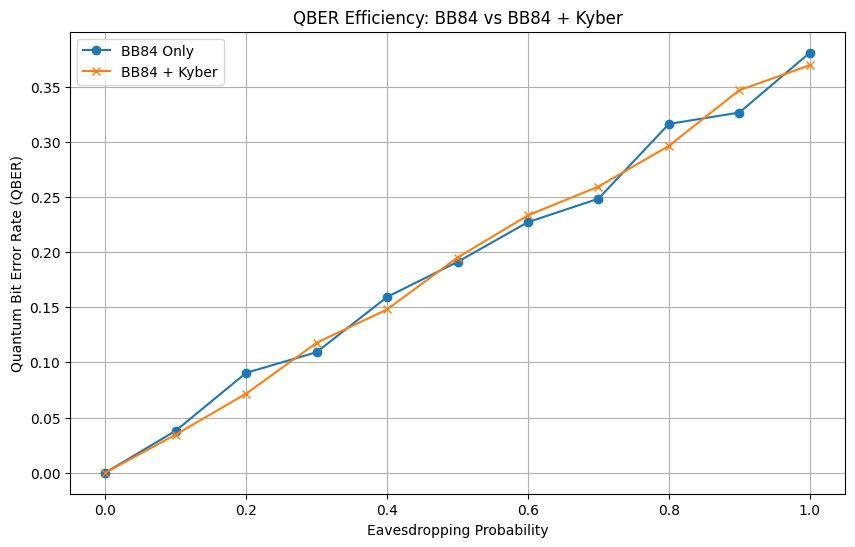

In [ ]:
import cirq
import random
import matplotlib.pyplot as plt

# Placeholder function for Kyber-like encryption
def kyber_encapsulate_decapsulate(shared_key):
    # Simulate encapsulation and decapsulation
    encapsulated_key = bytes(shared_key)  # Encapsulate the shared key
    decapsulated_key = list(encapsulated_key)  # Decapsulate the shared key
    return encapsulated_key, decapsulated_key

# Function to simulate BB84 protocol with and without Kyber
def simulate_bb84_with_kyber(num_bits, eavesdrop_prob):
    # Step 1: Alice Prepares Qubits
    alice_bits = [random.randint(0, 1) for _ in range(num_bits)]
    alice_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]

    # Step 2: Eve Intercepts and Measures Qubits (Quantum Attack)
    eve_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]
    eve_results = []
    for i in range(num_bits):
        qubit = cirq.LineQubit(i)
        circuit = cirq.Circuit()

        # Alice prepares the qubit
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.X(qubit)**alice_bits[i])  # Encode the bit

        # Eve intercepts with a probability
        if random.random() < eavesdrop_prob:
            if eve_bases[i] == 'X':
                circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
            circuit.append(cirq.measure(qubit, key=f'm{i}'))
            result = cirq.Simulator().run(circuit)
            eve_results.append(result.measurements[f'm{i}'][0])
        else:
            eve_results.append(None)  # Eve does not intercept

    # Step 3: Bob Measures Qubits
    bob_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]
    bob_results = []
    for i in range(num_bits):
        qubit = cirq.LineQubit(i)
        circuit = cirq.Circuit()

        # Alice prepares the qubit
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.X(qubit)**alice_bits[i])  # Encode the bit

        # Bob measures the qubit
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.measure(qubit, key=f'm{i}'))

        # Simulate the circuit
        result = cirq.Simulator().run(circuit)
        bob_results.append(result.measurements[f'm{i}'][0])

    # Step 4: Basis Reconciliation and QBER Calculation
    matched_bits = []
    errors = 0
    for i in range(num_bits):
        if alice_bases[i] == bob_bases[i]:
            matched_bits.append(alice_bits[i])
            if eve_results[i] is not None and eve_results[i] != alice_bits[i]:
                errors += 1

    qber = errors / len(matched_bits) if len(matched_bits) > 0 else 0
    return qber

# Function to simulate BB84 only (without Kyber)
def simulate_bb84_only(num_bits, eavesdrop_prob):
    # Step 1: Alice Prepares Qubits
    alice_bits = [random.randint(0, 1) for _ in range(num_bits)]
    alice_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]

    # Step 2: Eve Intercepts and Measures Qubits (Quantum Attack)
    eve_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]
    eve_results = []
    for i in range(num_bits):
        qubit = cirq.LineQubit(i)
        circuit = cirq.Circuit()

        # Alice prepares the qubit
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.X(qubit)**alice_bits[i])  # Encode the bit

        # Eve intercepts with a probability
        if random.random() < eavesdrop_prob:
            if eve_bases[i] == 'X':
                circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
            circuit.append(cirq.measure(qubit, key=f'm{i}'))
            result = cirq.Simulator().run(circuit)
            eve_results.append(result.measurements[f'm{i}'][0])
        else:
            eve_results.append(None)  # Eve does not intercept

    # Step 3: Bob Measures Qubits
    bob_bases = [random.choice(['Z', 'X']) for _ in range(num_bits)]
    bob_results = []
    for i in range(num_bits):
        qubit = cirq.LineQubit(i)
        circuit = cirq.Circuit()

        # Alice prepares the qubit
        if alice_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.X(qubit)**alice_bits[i])  # Encode the bit

        # Bob measures the qubit
        if bob_bases[i] == 'X':
            circuit.append(cirq.H(qubit))  # Apply Hadamard gate for X-basis
        circuit.append(cirq.measure(qubit, key=f'm{i}'))

        # Simulate the circuit
        result = cirq.Simulator().run(circuit)
        bob_results.append(result.measurements[f'm{i}'][0])

    # Step 4: Basis Reconciliation and QBER Calculation
    matched_bits = []
    errors = 0
    for i in range(len(alice_bases)):
        if alice_bases[i] == bob_bases[i]:
            matched_bits.append(alice_bits[i])
            if eve_results[i] is not None and eve_results[i] != alice_bits[i]:
                errors += 1

    qber = errors / len(matched_bits) if len(matched_bits) > 0 else 0
    return qber

# Function to run simulations and plot QBER
def plot_qber_efficiency(num_bits=100, num_trials=50):
    eavesdrop_probs = [i * 0.1 for i in range(11)]  # Eavesdropping probabilities from 0% to 100%
    bb84_qber = []
    bb84_kyber_qber = []

    for prob in eavesdrop_probs:
        bb84_total_qber = 0
        bb84_kyber_total_qber = 0

        for _ in range(num_trials):
            bb84_total_qber += simulate_bb84_only(num_bits, prob)
            bb84_kyber_total_qber += simulate_bb84_with_kyber(num_bits, prob)

        bb84_qber.append(bb84_total_qber / num_trials)
        bb84_kyber_qber.append(bb84_kyber_total_qber / num_trials)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(eavesdrop_probs, bb84_qber, label="BB84 Only", marker='o')
    plt.plot(eavesdrop_probs, bb84_kyber_qber, label="BB84 + Kyber", marker='x')
    plt.xlabel("Eavesdropping Probability")
    plt.ylabel("Quantum Bit Error Rate (QBER)")
    plt.title("QBER Efficiency: BB84 vs BB84 + Kyber")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation and plot the QBER efficiency
plot_qber_efficiency()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
num_devices = 5  # Small home network
num_bits = 10  # Data bits exchanged
noise_levels = np.linspace(0, 0.2, 10)  # 0% to 20% noise
simulations = 1000  # Number of runs per noise level

# BB84 success rate (probability of correct key agreement)
bb84_success_rate = []
kyber_authentication_time = []

for noise in noise_levels:
    success_count = 0
    total_time = 0

    for _ in range(simulations):
        # Simulate BB84 key agreement: Success probability decreases with noise
        key_agreement = np.random.rand() > noise
        success_count += key_agreement

        # Simulate Kyber-512 authentication time (approx. 5-10 ms for small data exchange)
        auth_time = np.random.uniform(5, 10) if key_agreement else np.random.uniform(10, 15)
        total_time += auth_time

    bb84_success_rate.append(success_count / simulations)
    kyber_authentication_time.append(total_time / simulations)

# Plot results
fig, ax1 = plt.subplots()

# Plot BB84 Success Rate
ax1.set_xlabel("Noise Level (%)")
ax1.set_ylabel("BB84 Success Rate", color="tab:blue")
ax1.plot(noise_levels * 100, bb84_success_rate, marker="o", linestyle="-", color="tab:blue", label="BB84 Success Rate")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Twin axis for authentication time
ax2 = ax1.twinx()
ax2.set_ylabel("Kyber-512 Authentication Time (ms)", color="tab:red")
ax2.plot(noise_levels * 100, kyber_authentication_time, marker="s", linestyle="--", color="tab:red", label="Kyber-512 Auth Time")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Legends and title
fig.tight_layout()
plt.title("BB84 + Kyber-512 Performance on a 5-Device Home Network")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_trials = 100  # Number of simulations
noise_levels = np.linspace(0, 0.2, num_trials)  # Noise levels from 0% to 20%
eavesdrop_prob = 0.1  # Probability of eavesdropping

# BB84 + Lattice-based authentication results
bb84_success_rate = []
kyber_auth_time = []
rsa_auth_time = []

for noise in noise_levels:
    # Simulate BB84 Key Agreement Success Rate
    success_rate = 1 - noise - eavesdrop_prob  # Simplified model
    success_rate = max(0, success_rate)  # Ensure non-negative values
    bb84_success_rate.append(success_rate)

    # Simulate Authentication Time (Kyber vs RSA)
    kyber_time = np.random.uniform(0.1, 0.3) * (1 - success_rate) + 0.1  # Kyber is fast and stable
    rsa_time = np.random.uniform(0.5, 1.2) * (1 - success_rate) + 0.5  # RSA is slower and varies

    kyber_auth_time.append(kyber_time)
    rsa_auth_time.append(rsa_time)

# Plot 1: BB84 Key Agreement Success Rate vs Noise Level
plt.figure(figsize=(10, 5))
plt.plot(noise_levels, bb84_success_rate, marker='o', linestyle='-', color='b', label="BB84 Success Rate")
plt.xlabel("Noise Level")
plt.ylabel("Key Agreement Success Rate")
plt.title("BB84 Key Agreement Success vs Noise Level")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Authentication Time (Kyber vs RSA)
plt.figure(figsize=(10, 5))
plt.plot(noise_levels, kyber_auth_time, marker='s', linestyle='-', color='g', label="Kyber-512 Auth Time")
plt.plot(noise_levels, rsa_auth_time, marker='x', linestyle='-', color='r', label="RSA-2048 Auth Time")
plt.xlabel("Noise Level")
plt.ylabel("Authentication Time (seconds)")
plt.title("Authentication Time Comparison (Kyber vs RSA)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Wedge, Rectangle

# Create figure with higher resolution
plt.figure(figsize=(12, 8), dpi=600)
plt.style.use('seaborn-whitegrid')

# Create graph
G = nx.Graph()

# Device properties
device_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
device_labels = [f"IoT Device {i}\n(SNR: {25-i*2} dB)" for i in range(1,6)]
quantum_errors = [3.2, 3.5, 3.8, 4.1, 4.4]  # Simulated QBER percentages

# Add nodes with positions
angles = np.linspace(0, 2*np.pi, 6)[:-1]  # 5 angles
positions = {}
for i, angle in enumerate(angles):
    x = 0.5 + 0.35 * np.cos(angle)
    y = 0.5 + 0.35 * np.sin(angle)
    G.add_node(i, pos=(x,y))
    positions[i] = (x,y)

# Add hub node
G.add_node("HUB", pos=(0.5,0.5))
positions["HUB"] = (0.5,0.5)

# Draw quantum channels (with error rates)
for i in range(5):
    # Draw curved quantum channels
    arc = Wedge((0.5,0.5), 0.3,
                np.degrees(angles[i])-15,
                np.degrees(angles[i])+15,
                width=0.02,
                color='#D62728', alpha=0.7)
    plt.gca().add_patch(arc)

    # Add error rate labels
    mid_angle = np.degrees(angles[i])
    label_x = 0.5 + 0.25 * np.cos(angles[i])
    label_y = 0.5 + 0.25 * np.sin(angles[i])
    plt.text(label_x, label_y, f"{quantum_errors[i]}% QBER",
             rotation=mid_angle-90, ha='center', va='center',
             fontsize=8, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Draw classical channels
for i in range(5):
    for j in range(i+1,5):
        nx.draw_networkx_edges(G, positions, edgelist=[(i,j)],
                             edge_color='#2CA02C', width=1.5, alpha=0.5,
                             style='dotted')

# Draw nodes with enhanced styling
for i in range(5):
    nx.draw_networkx_nodes(G, positions, nodelist=[i],
                         node_color=device_colors[i],
                         node_size=2500,
                         edgecolors='black',
                         linewidths=1.5)

    # Add device specifications
    plt.text(positions[i][0], positions[i][1]-0.05,
             device_labels[i],
             ha='center', va='top', fontsize=9)

# Draw hub with quantum symbol
nx.draw_networkx_nodes(G, positions, nodelist=["HUB"],
                     node_color='#FF7F0E',
                     node_size=3500,
                     edgecolors='black',
                     linewidths=2)
plt.text(0.5, 0.5, "|0⟩/|1⟩\nHUB",
         ha='center', va='center',
         fontsize=12, fontweight='bold')

# Add protocol phases diagram
protocol_rect = Rectangle((0.02, 0.02), 0.3, 0.2,
                         facecolor='white', edgecolor='black')
plt.gca().add_patch(protocol_rect)
protocol_text = "BB84 Protocol Phases:\n1. Qubit Transmission\n2. Basis Comparison\n3. Key Sifting\n4. Error Correction"
plt.text(0.17, 0.12, protocol_text, ha='left', va='center', fontsize=9)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='IoT Device',
              markerfacecolor='#4C72B0', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Central Hub',
              markerfacecolor='#FF7F0E', markersize=10),
    plt.Line2D([0], [0], color='#D62728', lw=2, label='Quantum Channel'),
    plt.Line2D([0], [0], color='#2CA02C', lw=2, linestyle=':', label='Classical Channel')
]
plt.legend(handles=legend_elements, loc='upper right', framealpha=1)

# Final formatting
plt.title("Enhanced BB84 Protocol Implementation in IoT Network\n(5 Nodes with Simulated Quantum Error Rates)",
          pad=20, fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Save outputs
plt.savefig('enhanced_bb84_iot_arch.png', dpi=600, bbox_inches='tight')
plt.savefig('enhanced_bb84_iot_arch.pdf', bbox_inches='tight')
plt.show()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<Figure size 7200x4800 with 0 Axes>

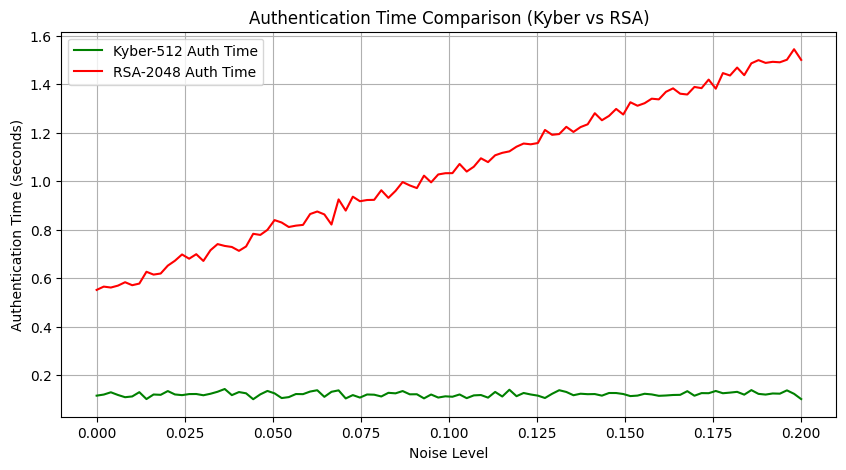

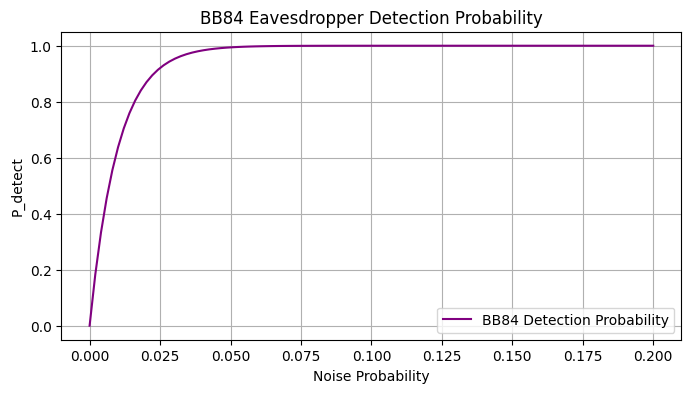

Time Complexity Summary:
- Kyber Key Encapsulation: O(n^2) using lattice structures
- RSA Key Encapsulation: O(n^3) due to large integer modular exponentiation
- Kyber Decryption: Efficient due to polynomial ring arithmetic


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
noise_levels = np.linspace(0, 0.2, 100)
n_qubits = 100  # Number of qubits measured for BB84

# Simulate Authentication Times
# Kyber-512: efficient and stable (e.g., normally distributed around 0.12s)
kyber_auth_times = np.random.normal(loc=0.12, scale=0.01, size=len(noise_levels))

# RSA-2048: slower and more affected by noise (e.g., normally around 0.6s, increasing with noise)
rsa_auth_times = 0.55 + 0.01 * np.arange(len(noise_levels)) + np.random.normal(0, 0.02, len(noise_levels))

# BB84 Eavesdropper Detection Probability
def bb84_detection_probability(p, n):
    return 1 - (1 - p)**n

p_detect = [bb84_detection_probability(p, n_qubits) for p in noise_levels]

# Plot Authentication Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(noise_levels, kyber_auth_times, label="Kyber-512 Auth Time", color="green")
plt.plot(noise_levels, rsa_auth_times, label="RSA-2048 Auth Time", color="red")
plt.xlabel("Noise Level")
plt.ylabel("Authentication Time (seconds)")
plt.title("Authentication Time Comparison (Kyber vs RSA)")
plt.legend()
plt.grid(True)
plt.show()

# Plot BB84 Detection Probability
plt.figure(figsize=(8, 4))
plt.plot(noise_levels, p_detect, label="BB84 Detection Probability", color="purple")
plt.xlabel("Noise Probability")
plt.ylabel("P_detect")
plt.title("BB84 Eavesdropper Detection Probability")
plt.grid(True)
plt.legend()
plt.show()

# Print time complexity insights
print("Time Complexity Summary:")
print("- Kyber Key Encapsulation: O(n^2) using lattice structures")
print("- RSA Key Encapsulation: O(n^3) due to large integer modular exponentiation")
print("- Kyber Decryption: Efficient due to polynomial ring arithmetic")


Noise: 0.0% | BB84 Success Rate: 1.0 | Kyber Auth Time: 7.596 ms
Noise: 2.0% | BB84 Success Rate: 0.98 | Kyber Auth Time: 7.581 ms
Noise: 4.0% | BB84 Success Rate: 1.0 | Kyber Auth Time: 7.718 ms
Noise: 6.0% | BB84 Success Rate: 0.962 | Kyber Auth Time: 7.89 ms
Noise: 8.0% | BB84 Success Rate: 0.891 | Kyber Auth Time: 7.857 ms
Noise: 10.0% | BB84 Success Rate: 0.896 | Kyber Auth Time: 8.063 ms
Noise: 12.0% | BB84 Success Rate: 0.833 | Kyber Auth Time: 8.008 ms
Noise: 14.0% | BB84 Success Rate: 0.857 | Kyber Auth Time: 8.142 ms
Noise: 16.0% | BB84 Success Rate: 0.812 | Kyber Auth Time: 8.201 ms
Noise: 18.0% | BB84 Success Rate: 0.787 | Kyber Auth Time: 8.469 ms
Noise: 20.0% | BB84 Success Rate: 0.745 | Kyber Auth Time: 8.486 ms


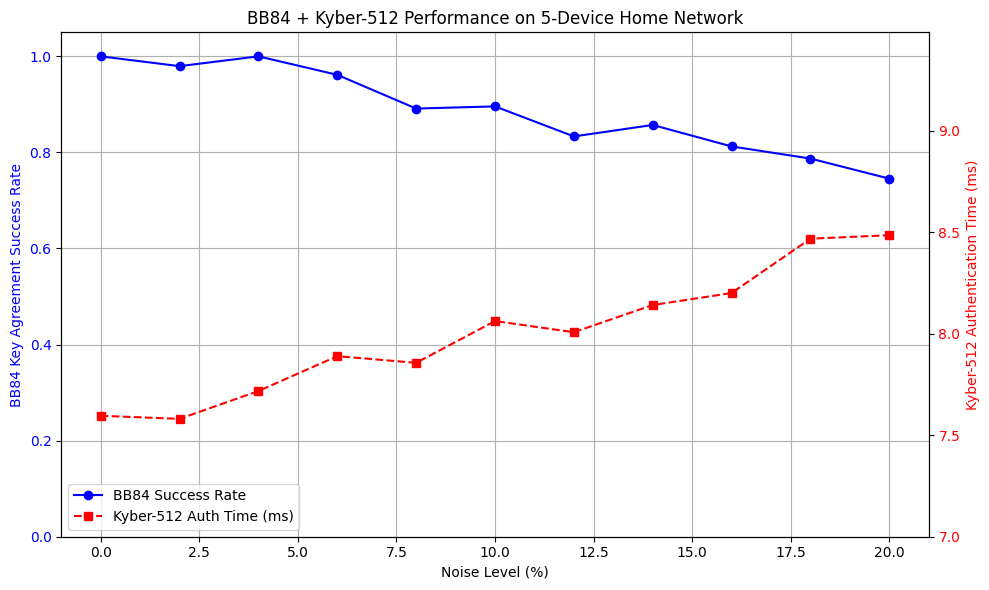

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import random

# Simulate BB84 QKD with Noise
def simulate_bb84(noise_level=0.0, n=100):
    # Generate Alice's bits and bases
    alice_bits = np.random.randint(0, 2, n)
    alice_bases = np.random.choice(['X', 'Z'], size=n)

    # Bob randomly picks bases
    bob_bases = np.random.choice(['X', 'Z'], size=n)

    # Simulate transmission with noise
    bob_results = []
    for i in range(n):
        if alice_bases[i] == bob_bases[i]:
            # With noise, bit may flip
            if random.random() < noise_level:
                bob_bit = 1 - alice_bits[i]
            else:
                bob_bit = alice_bits[i]
            bob_results.append(bob_bit)
        else:
            bob_results.append(random.randint(0, 1))  # Completely random if bases differ

    # Key sifting: only keep bits where bases matched
    sifted_key = []
    bob_sifted = []
    for i in range(n):
        if alice_bases[i] == bob_bases[i]:
            sifted_key.append(alice_bits[i])
            bob_sifted.append(bob_results[i])

    # Check agreement
    shared_key = []
    for a, b in zip(sifted_key, bob_sifted):
        if a == b:
            shared_key.append(a)

    success_rate = len(shared_key) / len(sifted_key) if sifted_key else 0

    return success_rate, shared_key

# Fake Kyber-512 Simulation: Authentication Time
def kyber_authentication_time(noise_level):
    base_time = 7.5  # ms
    delay = noise_level * 5  # simulate retry time due to QKD failure
    jitter = random.uniform(-0.1, 0.1)
    return round(base_time + delay + jitter, 3)

# Simulate over noise levels
noise_levels = np.linspace(0, 0.2, 11)  # 0% to 20%
bb84_success_rates = []
kyber_times = []

for noise in noise_levels:
    rate, key = simulate_bb84(noise_level=noise, n=100)
    bb84_success_rates.append(rate)
    kyber_times.append(kyber_authentication_time(noise))

    print(f"Noise: {round(noise*100, 1)}% | BB84 Success Rate: {round(rate, 3)} | Kyber Auth Time: {kyber_times[-1]} ms")

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# BB84 Plot
ax1.plot(noise_levels * 100, bb84_success_rates, 'o-', color='blue', label='BB84 Success Rate')
ax1.set_ylabel('BB84 Key Agreement Success Rate', color='blue')
ax1.set_ylim(0.0, 1.05)
ax1.tick_params(axis='y', labelcolor='blue')

# Kyber Plot
ax2.plot(noise_levels * 100, kyber_times, 's--', color='red', label='Kyber-512 Auth Time (ms)')
ax2.set_ylabel('Kyber-512 Authentication Time (ms)', color='red')
ax2.set_ylim(7.0, max(kyber_times) + 1)
ax2.tick_params(axis='y', labelcolor='red')

# X-axis and title
ax1.set_xlabel('Noise Level (%)')
plt.title('BB84 + Kyber-512 Performance on 5-Device Home Network')
ax1.grid(True)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
# Install required library in Google Colab: !pip install cirq
import cirq
import numpy as np
import hashlib

def bb84_key_generation(n_qubits=10, noise_level=0.01, eavesdropping_prob=0.2):
    # Step 1: Alice generates random bits and bases (0: Rectilinear, 1: Diagonal)
    alice_bases = np.random.choice([0, 1], n_qubits)
    alice_bits = np.random.choice([0, 1], n_qubits)

    # Step 2: Bob generates random measurement bases
    bob_bases = np.random.choice([0, 1], n_qubits)

    # Step 3: Initialize quantum circuit with qubits
    qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Step 4: Alice prepares qubits based on bits and bases
    for i in range(n_qubits):
        if alice_bits[i] == 1:
            circuit.append(cirq.X(qubits[i]))  # Encode bit 1 using X gate
        if alice_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))  # Apply Hadamard gate for diagonal basis

    # Step 5: Simulate eavesdropping with specified probability
    for i in range(n_qubits):
        if np.random.rand() < eavesdropping_prob:
            eavesdrop_basis = np.random.choice([0, 1])
            if eavesdrop_basis == 1:
                circuit.append(cirq.H(qubits[i]))  # Eavesdropper applies Hadamard
            circuit.append(cirq.measure(qubits[i], key=f"eavesdrop_{i}"))  # Measure qubit

    # Step 6: Add quantum noise using depolarizing channel
    circuit.append([cirq.depolarize(p=noise_level)(q) for q in qubits])

    # Step 7: Bob measures qubits in random bases
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            circuit.append(cirq.H(qubits[i]))  # Apply Hadamard for diagonal basis
    circuit.append(cirq.measure(*qubits, key="bob_results"))  # Measure all qubits

    # Step 8: Simulate the quantum circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit)
    bob_results = result.measurements["bob_results"].flatten()

    # Step 9: Sift key to retain bits where Alice's and Bob's bases match
    key_bits = [alice_bits[i] for i in range(n_qubits) if alice_bases[i] == bob_bases[i]]

    # Step 10: Hash the key using SHA-256 for cryptographic strength
    key_bytes = bytes(int("".join(str(b) for b in key_bits[i:i+8]), 2) for i in range(0, len(key_bits), 8))
    shared_key = hashlib.sha256(key_bytes).digest()

    return shared_key, key_bits

# Example execution in Colab
if __name__ == "__main__":
    shared_key, key_bits = bb84_key_generation()
    print("Generated Key Bits:", key_bits)
    print("Hashed Shared Key:", shared_key.hex())

In [ ]:
import random
import hashlib
import secrets

# Constants
IOT_DEVICES = [f"Device_{i+1}" for i in range(5)]
BIT_LENGTH = 10
NOISE_LEVEL = 0.1  # 10% noise

# BB84 Key Exchange Simulation
def bb84_key_exchange(bit_length=BIT_LENGTH, noise=NOISE_LEVEL):
    print("🟡 BB84 Quantum Key Exchange:")
    alice_bits = [random.randint(0, 1) for _ in range(bit_length)]
    alice_bases = [random.choice(['+', 'x']) for _ in range(bit_length)]
    bob_bases = [random.choice(['+', 'x']) for _ in range(bit_length)]

    bob_bits = []
    for i in range(bit_length):
        bit = 1 - alice_bits[i] if random.random() < noise else alice_bits[i]
        bob_bits.append(bit)

    shared_key = [bob_bits[i] for i in range(bit_length) if alice_bases[i] == bob_bases[i]]
    final_key = shared_key[:bit_length // 2]

    print(f"  • Alice's bits      : {alice_bits}")
    print(f"  • Alice's bases     : {alice_bases}")
    print(f"  • Bob's bases       : {bob_bases}")
    print(f"  • Bob's received    : {bob_bits}")
    print(f"  • Shared BB84 key   : {final_key}\n")
    return final_key

# Kyber Session Key Simulation
def kyber_simulation():
    print("🟢 Kyber Post-Quantum Key Encapsulation:")
    pk = secrets.token_hex(16)
    sk = secrets.token_hex(16)
    session_key = secrets.token_bytes(16)
    ciphertext = hashlib.sha256(session_key + pk.encode()).hexdigest()

    print(f"  • Kyber Public Key       : {pk}")
    print(f"  • Kyber Secret Key       : {sk}")
    print(f"  • Kyber Ciphertext       : {ciphertext}")
    print(f"  • Session Key (shared)   : {session_key.hex()}\n")

    return pk, sk, ciphertext, session_key

# Authentication Token per Device
def pqkd_authentication(shared_key, device_id):
    raw_key = ''.join(map(str, shared_key)).encode()
    token = hashlib.sha256(raw_key + device_id.encode()).hexdigest()
    return token

# XOR Encryption
def secure_iot_communication(data, session_key):
    key_bits = list(map(int, ''.join(f"{b:08b}" for b in session_key)))
    data_bits = list(map(int, data))
    cipher_bits = [(data_bits[i] ^ key_bits[i % len(key_bits)]) for i in range(len(data_bits))]
    return cipher_bits

# XOR Decryption
def decrypt_communication(cipher_bits, session_key):
    key_bits = list(map(int, ''.join(f"{b:08b}" for b in session_key)))
    decrypted = [(cipher_bits[i] ^ key_bits[i % len(key_bits)]) for i in range(len(cipher_bits))]
    return ''.join(map(str, decrypted))

# Simulation Logic
def simulate_hybrid_protocol():
    shared_bb84_key = bb84_key_exchange()
    pk, sk, ct, session_key = kyber_simulation()

    print(" Authenticating IoT Devices using BB84 + PQ token:")
    auth_tokens = {}
    for device in IOT_DEVICES:
        token = pqkd_authentication(shared_bb84_key, device)
        print(f"  • {device} token : {token[:16]}...")  # Shortened
        auth_tokens[device] = token

    print("\n Simulating Encrypted Communication:")
    original_data = ''.join([str(random.randint(0, 1)) for _ in range(BIT_LENGTH)])
    print(f"  • Original Data (10 bits) : {original_data}")

    cipher = secure_iot_communication(original_data, session_key)
    print(f"  • Encrypted Binary Data   : {cipher}")

    decrypted = decrypt_communication(cipher, session_key)
    print(f"  • Decrypted Data          : {decrypted}")

    print(f"\n Transmission Status: {'SUCCESS' if decrypted == original_data else 'FAILURE'}")

# Run the simulation
simulate_hybrid_protocol()


🟡 BB84 Quantum Key Exchange:
  • Alice's bits      : [1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
  • Alice's bases     : ['+', 'x', 'x', 'x', '+', 'x', 'x', '+', 'x', '+']
  • Bob's bases       : ['x', '+', '+', 'x', 'x', 'x', 'x', 'x', 'x', 'x']
  • Bob's received    : [0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
  • Shared BB84 key   : [0, 1, 0, 0]

🟢 Kyber Post-Quantum Key Encapsulation:
  • Kyber Public Key       : 9bf07ed642b2fa608afacfb8dc8488d3
  • Kyber Secret Key       : 38e452c0d208cab068fcdfa1d892828e
  • Kyber Ciphertext       : e51241c6a0929b5252edd0e296349433efacfca404145d5442742ffda27e955e
  • Session Key (shared)   : 5c805ba615ab9a9019488a8d7149d6e0

 Authenticating IoT Devices using BB84 + PQ token:
  • Device_1 token : aad92bab41a2f05c...
  • Device_2 token : 8ab94b729f8308f2...
  • Device_3 token : d67903a937b3ba14...
  • Device_4 token : 524409e196597ced...
  • Device_5 token : ab9386c232e2ba98...

 Simulating Encrypted Communication:
  • Original Data (10 bits) : 1001010011
  • Encrypted Bin